## PreAnalysis

In [3]:
from sklearn.metrics import mutual_info_score
import pandas as pd
import numpy as np
from sklearn.feature_selection import mutual_info_regression
import matplotlib.pyplot as plt
import seaborn as sns

df = pd.read_csv(f'Air2UG_alltimeseries_Deadhorse_MERRA2data.csv',header=0)
soil_temp_columns = ['T0','T_12','T_22','T_32','T_62','T_72']

# Extract time info
df['Date'] = df['Date'].apply(pd.to_datetime, errors='coerce')
df['Year'] = df['Date'].dt.year
df['Month'] = df['Date'].dt.month
df['Day'] = df['Date'].dt.day

remote_sensing_features = ['Day','Month','Year'] + ['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']

# Define a function to calculate entropy
def calculate_entropy(variable):
    # First we discretize the continuous variables into bins
    # The number of bins is set to the square root of the number of unique values, a common heuristic
    counts, _ = np.histogram(variable, bins='auto')
    # Normalize the counts to get a probability distribution
    p = counts / counts.sum()
    # Calculate the entropy
    entropy = -np.sum(p * np.log2(p + 1e-9))  # add a small value to prevent log(0)
    return entropy

# Calculate entropy for each remote sensing feature
entropies = {feature: calculate_entropy(df[feature]) for feature in soil_temp_columns}

# Calculate conditional entropy for soil temperatures given each remote sensing feature
# We will use mutual information and the formula H(X|Y) = H(X) - I(X;Y)
# where H is entropy, I is mutual information
conditional_entropies = {}
for soil_temp in soil_temp_columns:
    soil_temp_entropy = calculate_entropy(df[soil_temp])
    for feature in remote_sensing_features:
        mutual_info = mutual_info_regression(df[[feature]], df[soil_temp])[0]
        conditional_entropy = soil_temp_entropy - mutual_info
        conditional_entropies[(soil_temp, feature)] = conditional_entropy

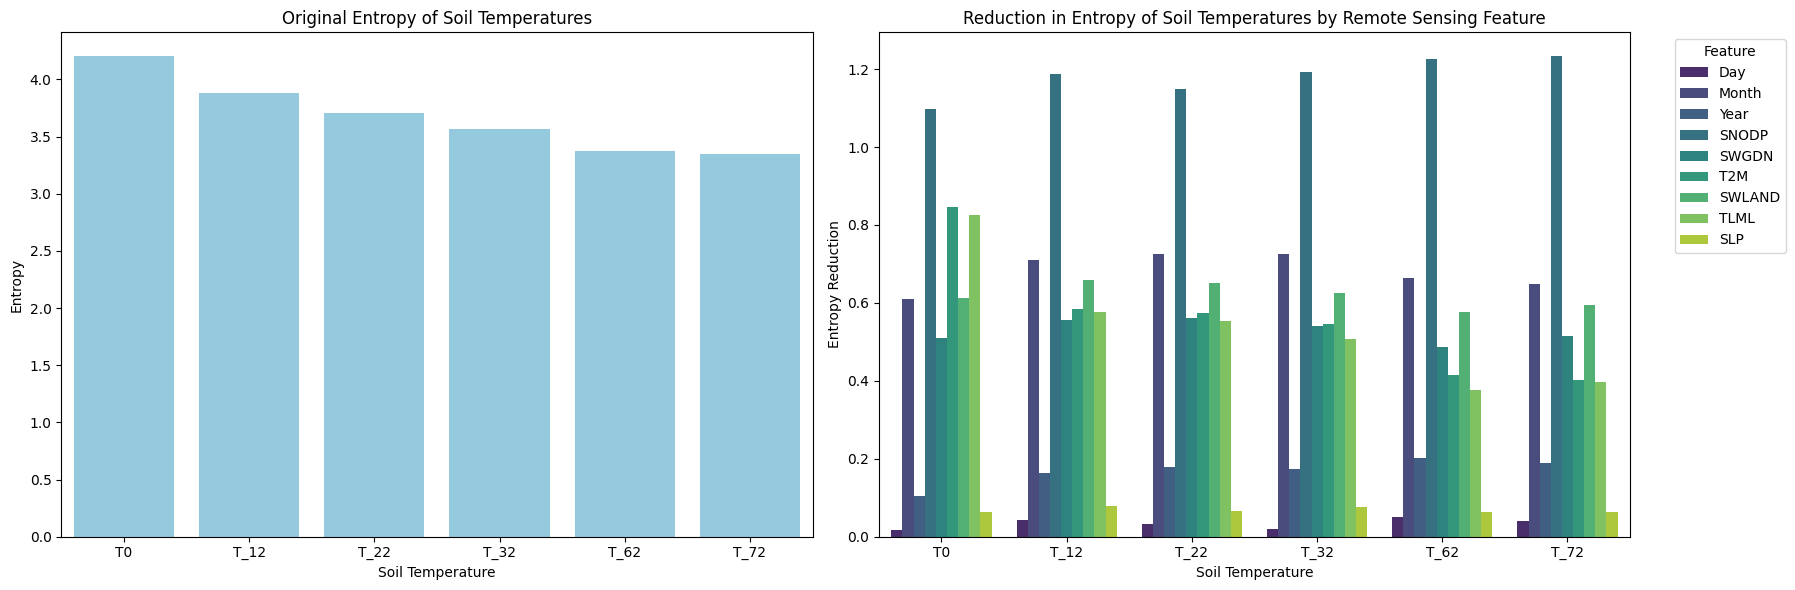

In [4]:
# Create a DataFrame from the original entropies for ease of plotting
df_original_entropies = pd.DataFrame(list(entropies.items()), columns=['Soil Temp', 'Original Entropy'])

# Create a DataFrame from the conditional entropies provided for ease of plotting
df_conditional_entropies = pd.DataFrame({
    'Soil Temp': [k[0] for k in conditional_entropies.keys()],
    'Feature': [k[1] for k in conditional_entropies.keys()],
    'Conditional Entropy': list(conditional_entropies.values())
})

# Calculate the reduction in entropy
df_conditional_entropies = df_conditional_entropies.join(
    df_original_entropies.set_index('Soil Temp'), on='Soil Temp')
df_conditional_entropies['Entropy Reduction'] = df_conditional_entropies['Original Entropy'] - df_conditional_entropies['Conditional Entropy']
# Export file
df_conditional_entropies.to_csv('Entropies_ConditionalEntropies_Deadhorse.csv', index=False)

# Now let's plot the original and conditional entropies
fig, axes = plt.subplots(nrows=1, ncols=2, figsize=(18, 6))

# Original entropy bar plot
sns.barplot(ax=axes[0], x='Soil Temp', y='Original Entropy', data=df_original_entropies, color='skyblue')
axes[0].set_title('Original Entropy of Soil Temperatures')
axes[0].set_ylabel('Entropy')
axes[0].set_xlabel('Soil Temperature')

# Entropy reduction bar plot
sns.barplot(ax=axes[1], x='Soil Temp', y='Entropy Reduction', hue='Feature', data=df_conditional_entropies, palette='viridis')
axes[1].set_title('Reduction in Entropy of Soil Temperatures by Remote Sensing Feature')
axes[1].set_ylabel('Entropy Reduction')
axes[1].set_xlabel('Soil Temperature')
axes[1].legend(title='Feature', bbox_to_anchor=(1.05, 1), loc='upper left')

plt.tight_layout()
plt.show()


<Axes: title={'center': 'Seasonal Component'}>

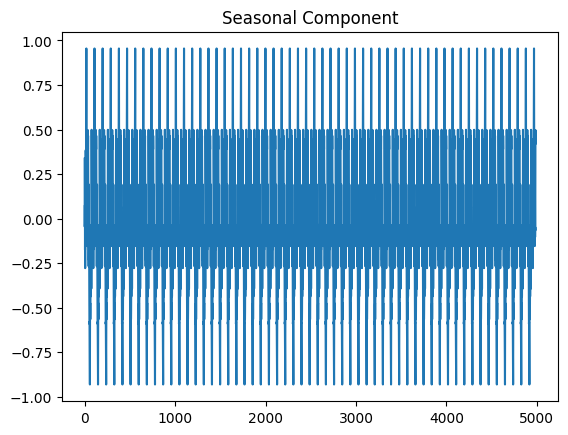

In [8]:
# Importing necessary libraries for ANOVA
import pandas as pd
from statsmodels.formula.api import ols
import statsmodels.api as sm

# Load your dataframe here
# df = pd.read_csv('path_to_your_data.csv')  # Uncomment this line and replace with your file path

# For this example, we'll create a dummy dataframe
# Assuming the df has a 'target_variable', 'season', and 'year' column
np.random.seed(0)  # For reproducible results
df = pd.DataFrame({
    'target_variable': np.random.rand(100),  # Replace with your actual target variable
    'season': np.random.choice(['Spring', 'Summer', 'Fall', 'Winter'], size=100),  # Replace with your actual season data
    'year': np.random.choice([2019, 2020, 2021, 2022], size=100)  # Replace with your actual year data
})

# Perform ANOVA
model = ols('target_variable ~ C(season)', data=df).fit()
anova_results = sm.stats.anova_lm(model, typ=2)

# Print the ANOVA table
print(anova_results)


### Get MERRA2 data first (already done!)

In [1]:
# !pip install earthengine-api --upgrade
import ee

# Trigger the authentication flow.
ee.Authenticate()

# Initialize the library.
ee.Initialize()

def resampler(coll, freq, unit, scale_factor, band_name):
    """
    This function aims to resample the time scale of an ee.ImageCollection.
    The function returns an ee.ImageCollection with the mean value of the
    band on the selected frequency.

    coll: (ee.ImageCollection) only one band can be handled
    freq: (int) corresponds to the resampling frequence
    unit: (str) corresponds to the resampling time unit.
                must be 'day', 'month' or 'year'
    scale_factor (float): scaling factor used to get our value in the good unit
    band_name (str) name of the output band
    """

    # Define initial and final dates of the collection.
    firstdate = ee.Date(
        coll.sort("system:time_start", True).first().get("system:time_start")
    )

    lastdate = ee.Date(
        coll.sort("system:time_start", False).first().get("system:time_start")
    )

    # Calculate the time difference between both dates.
    # https://developers.google.com/earth-engine/apidocs/ee-date-difference
    diff_dates = lastdate.difference(firstdate, unit)

    # Define a new time index (for output).
    new_index = ee.List.sequence(0, ee.Number(diff_dates), freq)

    # Define the function that will be applied to our new time index.
    def apply_resampling(date_index):
        # Define the starting date to take into account.
        startdate = firstdate.advance(ee.Number(date_index), unit)

        # Define the ending date to take into account according
        # to the desired frequency.
        enddate = firstdate.advance(ee.Number(date_index).add(freq), unit)

        # Calculate the composite image.
        image = (
            coll.filterDate(startdate, enddate)
            .mean()
            .multiply(scale_factor)
            .rename(band_name)
        )

        # Return the final image with the appropriate time index.
        return image.set("system:time_start", startdate.millis())

    # Map the function to the new time index.
    res = new_index.map(apply_resampling)

    # Transform the result into an ee.ImageCollection.
    res = ee.ImageCollection(res)

    return res

Enter verification code: 4/1AfJohXny1za_MG0XWgBTYBypIGOnH_YfQBhdZzWhhWeayXPBMFJn4jZ8PDw

Successfully saved authorization token.


*** Earth Engine *** Share your feedback by taking our Annual Developer Satisfaction Survey: https://google.qualtrics.com/jfe/form/SV_doiqkQG3NJ1t8IS?source=API


In [5]:
import ee
import pandas as pd

# # Authenticate and Initialize Earth Engine
# ee.Authenticate()
# ee.Initialize()

# Define the region of interest
Deadhorse = ee.Geometry.Point([-148.469, 70.182])

# Define the time range
start_date = '1986-10-01'
end_date = '2004-01-01'

# List of MERRA2 collections
collections = [
    "NASA/GSFC/MERRA/flx/2",
    "NASA/GSFC/MERRA/lnd/2",
    "NASA/GSFC/MERRA/rad/2",
    "NASA/GSFC/MERRA/slv/2"
]

# Select the bands of interest for each collection
bands_of_interest = {
    "NASA/GSFC/MERRA/flx/2": ['TLML'],  #'GHTSKIN', 'HFLUX', 'SPEED', 'TSH'
    "NASA/GSFC/MERRA/lnd/2": ['SWLAND', 'SNODP'],#'EVPSOIL', 'GWETPROF', 'GWETROOT', 'GWETTOP', 'LWLAND', 
    "NASA/GSFC/MERRA/rad/2": ['SWGDN'],#, 'LWGAB'
    "NASA/GSFC/MERRA/slv/2": ['T2M']#'TS', 'QV2M', 'SLP',
}

# Create an empty dataframe to store results
df = pd.DataFrame()

# For each collection, extract the bands of interest and resample
for collection in collections:
    print(collection, end=':')
    for band in bands_of_interest[collection]:
        print(band, end=',')
        # Load the dataset
        dataset = ee.ImageCollection(collection).filterDate(start_date, end_date)
        
        # Resample the data using the provided function
        daily_data = resampler(dataset.select(band), 1, "day", 1, band)
        
        # Extract the data for the region of interest
        data_list = daily_data.getRegion(Deadhorse, 50).getInfo()
        
        # Convert to a Pandas DataFrame
        temp_df = pd.DataFrame(data_list[1:], columns=data_list[0])
        temp_df['time'] = pd.to_datetime(temp_df['time'], unit='ms')
        temp_df.set_index('time', inplace=True)
        temp_df = temp_df[[band]]
        
        # If df is empty, initialize it with temp_df, else join on the 'time' column
        if df.empty:
            df = temp_df
        else:
            df = df.join(temp_df, how='outer')
    print('')
            
df.to_csv(f'MERRA2_Deadhorse_dataprocessed_v2.csv')


NASA/GSFC/MERRA/flx/2:TLML,
NASA/GSFC/MERRA/lnd/2:SWLAND,SNODP,
NASA/GSFC/MERRA/rad/2:SWGDN,
NASA/GSFC/MERRA/slv/2:T2M,


## MODEL LEARNING

### START LEARNING:

#### START LEARNING:using the matlab processed dataset (already made sequences)

In [1]:
# Function to prepare sequences
def prepare_sequences(loc, sequence_length, target, features, season, res):
    # Reading the csv file
    resolution = 'res'+str(res)+'D_'  

    df = pd.read_csv(f'Air2UG_alltimeseries_{loc}_MERRA2data_{target}_{resolution}SeqLen{str(sequence_length)}_{season}.csv')

    # Initialize an empty list to hold feature columns
    feature_columns = []
    
    if len(features) > 0 and sequence_length > 1:
        # Loop through each feature and sequence length to get the corresponding columns
        for feature in features:
            for i in range(sequence_length):
                column_name = f"{feature}_{i+1}"
                if column_name in df.columns:
                    feature_columns.append(column_name)         
    elif len(features) > 0 and sequence_length == 1:
        # Loop through each feature and sequence length to get the corresponding columns
        for feature in features:
            for i in range(sequence_length):
                column_name = f"{feature}"
                if column_name in df.columns:
                    feature_columns.append(column_name)        
    else:
        feature_columns = []
        
    # Extract time info
    df['Date'] = df['Date'].apply(pd.to_datetime, errors='coerce')
    df['Year'] = df['Date'].dt.year
    feature_columns.append('Year')
    df['Month'] = df['Date'].dt.month
    feature_columns.append('Month')
    df['Day'] = df['Date'].dt.day
    feature_columns.append('Day')
    
    # Extract the feature columns for X
    X = df[feature_columns].values
    
    # Extract the target column for y
    y = df[target].values
    
    return X, y, df

In [5]:
# 14: SNODP, SWGDN, T2M, SWLAND, TLML, SLP, 
# 21: SNODP, Tair, LWGAB, T2M, SLP
import numpy as np
loc = 'Deadhorse'
sequence_length = 1
features = ''
trgt = 'T0'
res = 30
print(f'Res.;Season;sequence length;Target;Dataset size;# years;Training set size;# years')
for season in ['Winter','Spring','Summer','Autumn']:
        X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]
        print(f'{res};{season};{sequence_length};{trgt};{X.shape[0]};{np.unique(X[:,-3]).shape[0]};{X_train.shape[0]};{np.unique(X_train[:,-3]).shape[0]}')

Res.;Season;sequence length;Target;Dataset size;# years;Training set size;# years
30;Winter;1;T0;1264;15;1011;12
30;Spring;1;T0;1273;14;1018;12
30;Summer;1;T0;1196;13;956;11
30;Autumn;1;T0;1225;14;980;12


In [2]:
# load data into pandas dataframe
import pandas as pd
import numpy as np
# !pip install sktime
from lightgbm import LGBMRegressor
from sklearn.linear_model import LinearRegression, SGDRegressor
from sklearn.model_selection import train_test_split, GridSearchCV, RandomizedSearchCV
from sklearn.metrics import mean_squared_error, r2_score, mean_absolute_error, explained_variance_score
from sklearn.linear_model import LinearRegression
from sklearn.neighbors import KNeighborsRegressor
from sklearn.tree import DecisionTreeRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.neural_network import MLPRegressor
from sklearn.ensemble import GradientBoostingRegressor, HistGradientBoostingRegressor
from sklearn.preprocessing import StandardScaler
import time

# !pip install PrettyTable
from prettytable import PrettyTable

models = [{'model': LinearRegression(), 'params': {}},
          {'model': KNeighborsRegressor(n_jobs=-1), 'params': {'n_neighbors': range(3,23,3),
                                                      'weights': ['uniform', 'distance'],
                                                      'p': [1, 2]}},
          {'model': DecisionTreeRegressor(), 'params': {'max_depth': range(3,23,3),
                                                        'min_samples_split': [2, 4, 6, 8],
                                                        'min_samples_leaf': [1, 2, 3, 5]}},
          {'model': RandomForestRegressor(verbose=0, n_jobs=-1), 'params': {'n_estimators': [10, 20, 50, 70],
                                                        'max_depth': range(3,23,3),
                                                        'min_samples_split': [2, 4, 6],
                                                        'min_samples_leaf': [2, 4, 6]}},
          {'model':LGBMRegressor(n_jobs=-1, verbose=-1,force_col_wise=True), 'params': {'learning_rate': [0.1, 0.01, 0.001],
                                                           'n_estimators': [100,150,200,250,350,500,1000],
                                                           'num_leaves': [20, 31, 40, 60, 80],
                                                           'min_data_in_leaf': range(50,300, 100)}},
          {'model':SVR(verbose=0), 'params':  {'C': [0.1, 1], #10, 100
                                      'gamma': [0.1, 0.01],#1, , 0.001
                                      'kernel': ['linear', 'rbf', 'sigmoid']}},# 'poly',
          {'model':MLPRegressor(verbose=False,max_iter=20000), 'params':  {'hidden_layer_sizes': [(50,50,50), (50,100,50), (100,50), (75,35)],
                                               'activation': ['relu','tanh'],#,'logistic'
                                               'alpha': [0.0001, 0.05]}}
          ]

# Function to scale features
def scale_features(X_train, X_test):
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)
    X_test_scaled = scaler.transform(X_test)
    return X_train_scaled, X_test_scaled

# for season in ['Winter','Spring','Summer','Autumn']:
#             X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
#             print(f'{season},{trgt},{X.shape}, {y.shape}')
#             # Split into train and test sets
#             train_size = int(len(X) * 0.8)
#             X_train, X_test = X[:train_size], X[train_size:]
#             y_train, y_test = y[:train_size], y[train_size:]
#             X_train_scaled, X_test_scaled = scale_features(X_train, X_test)   
#             X, y, splits = combine_split_data([X_train, X_test], [y_train, y_test])

#             print(f'{season},{trgt},{X.shape}, {y.shape}')

### direct process

In [11]:
#Time+Tair | TIME+Remote sensing
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score
from sklearn.experimental import enable_halving_search_cv # noqa
from sklearn.model_selection import HalvingGridSearchCV
from tsai.models.MINIROCKET import MiniRocketRegressor
from sklearn.metrics import mean_squared_error, make_scorer
rmse_scorer = make_scorer(mean_squared_error, greater_is_better=False)

# sequence length
sequence_length = 1
# resolution
loc = 'Deadhorse'
print(f'Res;seqLen;Season;trgt;model;Feature;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2')
# Prepare sequences
for res in [1, 7, 14, 30]:
    for season in ['Winter','Spring','Summer','Autumn']:
        for trgt in ['T0','T_12','T_22','T_32','T_62','T_72']:  
            for model in models:
                for features in [['Tair'], ['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']]:
                    print(f'{res};{sequence_length};{season};{trgt}',end=';')
                    print(str(model['model']).split('(')[0],end=';')
                    print(f'{features}',end=';')
                    X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
                #     print(X.shape)

                    # Split into train and test sets
                    train_size = int(len(X) * 0.8)
                    X_train, X_test = X[:train_size], X[train_size:]
                    y_train, y_test = y[:train_size], y[train_size:]

                    # Scale features
                    X_train_scaled, X_test_scaled = scale_features(X_train, X_test)   

                    # hyperparameter tuning
                    if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'LGBMRegressor':
                        model_final = HalvingGridSearchCV(model['model'], model['params'], cv=10, scoring='neg_mean_squared_error', verbose=0, n_jobs=-1)#n_iter=15,
                    elif str(model['model']).split('(')[0] == 'LGBMRegressor':
                        model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)
                    else:
                        model_final = model['model']

                    # Train model
                    start_train = time.time()
                    model_final.fit(X_train_scaled, y_train)
                    end_train = time.time()

                    # Evaluate training performance
                    y_pred_train = model_final.predict(X_train_scaled)
                    rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
                    r2_train = r2_score(y_train, y_pred_train)
                    mae_train = mean_absolute_error(y_train, y_pred_train)
                    explained_variance_train = explained_variance_score(y_train, y_pred_train)
                    train_duration = end_train - start_train

                    if str(model['model']).split('(')[0] != 'LinearRegression' and str(model['model']).split('(')[0] != 'LGBMRegressor':
                        print(f'{model_final.best_params_};{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')
                    elif str(model['model']).split('(')[0] == 'LGBMRegressor':
                        print(f'learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')
                    else:
                        print(f'-;{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')

                    # Test model
                    start_test = time.time()
                    y_pred_test = model_final.predict(X_test_scaled)
                    end_test = time.time()

                    # Evaluate testing performance
                    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
                    r2_test = r2_score(y_test, y_pred_test)
                    mae_test = mean_absolute_error(y_test, y_pred_test)
                    explained_variance_test = explained_variance_score(y_test, y_pred_test)
                    test_duration = end_test - start_test

                    print(f'{test_duration};{rmse_test};{mae_test};{explained_variance_test};{r2_test}')

                    # Write results to a CSV file
            #         formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
            #         formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
            #         y_test_df = pd.DataFrame(y_test, columns=['actual'])
            #         y_preds = pd.DataFrame(y_pred, columns=['preds'])
            #         results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
            #         results.to_csv(f'Results2/Preliminary{loc}_{trgt}_res{res}D_features{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
            print(f'')
        print(f'')
    print(f'')
    print(f'')
        

Res;seqLen;Season;trgt;model;Feature;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2
1;1;Winter;T0;LinearRegression;['Tair'];-;0.001668691635131836;4.792602818242713;3.5484010187055017;0.3682069628885648;0.3682069628885648;9.012222290039062e-05;3.8442657162931684;3.256543568077592;0.5069720567001776;0.1673668013032541
1;1;Winter;T0;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.002637147903442383;3.900656245952177;3.091040084129368;0.581488577885129;0.5814885778851291;0.00010967254638671875;5.304065584835136;4.213462695809454;-0.17729506241448934;-0.5850563157225632
1;1;Winter;T0;KNeighborsRegressor;['Tair'];{'n_neighbors': 18, 'p': 1, 'weights': 'uniform'};1.9669811725616455;3.3185424776607695;2.4490724255412686;0.6970870888706797;0.6970808568035565;0.012570381164550781;3.1986595430655402;2.690537988581467;0.6368216783070694;0.42354825163114196
1;1;Winter;T0;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 12, '

1;1;Winter;T_12;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};19.800442695617676;0.9494366861159986;0.7116320875790871;0.9545734570613578;0.9545187650984647;0.0003814697265625;3.8406217546017074;2.947318469363116;0.6583330078625943;0.3215227363349644

1;1;Winter;T_22;LinearRegression;['Tair'];-;0.0017185211181640625;2.9428826452274928;2.3603224917571954;0.6003558879503919;0.600355887950392;9.417533874511719e-05;3.1056878729330455;2.6755643749536278;0.6215160600912866;0.506981887457514
1;1;Winter;T_22;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0009191036224365234;2.7266988611684635;2.162834269606186;0.6569148783731464;0.6569148783731464;8.630752563476562e-05;3.389517637744019;2.845645574686923;0.5496281564502976;0.41274995522345814
1;1;Winter;T_22;KNeighborsRegressor;['Tair'];{'n_neighbors': 12, 'p': 1, 'weights': 'uniform'};0.5644047260284424;1.3962840926909978;1.1074727

1;1;Winter;T_72;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.26065921783447266;1.4811682117500595;1.0211746226739113;0.8835458405505157;0.883103911484332;0.00943303108215332;2.191200439152842;1.8491531163553718;0.7821576098499408;0.7559592472984648
1;1;Winter;T_72;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};27.25579524040222;1.7361382872603028;1.324761929271609;0.8424726764277065;0.8393947110004493;0.0003542900085449219;4.504690718405244;3.891828124379519;0.729752057886849;-0.031402312107330355
1;1;Winter;T_72;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)};15.733357429504395;0.7906841181375968;0.5919632543789718;0.9666929040871839;0.9666882656231504;0.0004336833953857422;3.0551934669403122;2.5020347742415323;0.7902919187293089;0.5255662493491655


1;1;Spring;T0;LinearRegression;['Tair'];-;0.00136

1;1;Spring;T_12;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.26097798347473145;1.4151653705845106;1.0496185434915923;0.9145773561229383;0.9139969101435376;0.010050535202026367;2.0181931176594876;1.6483340200530454;0.8462328421475025;0.7229763180699667
1;1;Spring;T_12;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)};29.379952669143677;2.278946254700371;1.7572723994584984;0.776975829169249;0.7769676628516367;0.000553131103515625;1.7227501407884283;1.4055567923250287;0.7983899902445224;0.798146611775241
1;1;Spring;T_12;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)};17.430394411087036;0.7490097031695367;0.5539569590653924;0.9764133586265145;0.9759079055668254;0.0009884834289550781;2.8501940373489205;2.337713975334048;0.7629258435243873;0.4474897874122218

1;1;Spring;T_22;LinearRegression;['Tair'];-;0.0013

1;1;Spring;T_72;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.21740269660949707;1.7373287047622459;1.2266709573629822;0.6984341744235703;0.6900953685167128;0.00844883918762207;1.3351399599443934;1.0289883648098317;0.7325441693207717;0.6923305646113983
1;1;Spring;T_72;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.2521510124206543;1.0599000213431884;0.7648694082119926;0.8850287371096311;0.8846563001631735;0.00959920883178711;1.341795573492171;1.0636130881948198;0.7454850335538541;0.6892554820839862
1;1;Spring;T_72;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};28.669521808624268;1.553248629037491;1.1818537744058213;0.7544742404471793;0.7522885770270172;0.0006544589996337891;2.0981331318822622;1.7323758789847967;0.5489113662014024;0.24020426804009654
1;1;Spring;T_72;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes

1;1;Summer;T_12;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.2273108959197998;1.3034566693137308;0.8896179140780966;0.7023320120979399;0.6934573027458137;0.007383584976196289;3.5017697734516604;2.774490923569302;0.4042634657445624;-0.4761210242543661
1;1;Summer;T_12;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.24239802360534668;1.1662985773362835;0.7354168010634528;0.7609904291741543;0.7545758649464872;0.008634567260742188;3.162538417221924;2.440637778678628;0.44690086930658035;-0.20397759811234506
1;1;Summer;T_12;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 50, 50)};13.538542747497559;0.37705834547491857;0.2668763509987537;0.9743677050535565;0.9743483744075822;0.0004918575286865234;2.957432862339602;2.4730325406067117;0.5234356490381873;-0.05287442197239667
1;1;Summer;T_12;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_l

1;1;Summer;T_72;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;0.9737098217010498;0.29510647234629594;0.1498946383693498;0.9641362069126058;0.9641362069126058;0.001482248306274414;0.37277260639772514;0.2914223303581288;0.8956441451314119;0.8795233893576736
1;1;Summer;T_72;LGBMRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;6.692306995391846;0.2714140874097128;0.14711803270596419;0.9696636363439142;0.9696636363439142;0.0015778541564941406;0.3848338812829745;0.29533290462136913;0.8948219534626196;0.871601082482053
1;1;Summer;T_72;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.45450854301452637;0.5546593235580418;0.31021507658602304;0.8742841653294264;0.8733073599189237;0.00555109977722168;0.369509456120676;0.2724478401435529;0.8943659807064784;0.8816233966415183
1;1;Summer;T_72;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C':

1;1;Autumn;T_12;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;0.9920175075531006;0.70147108013035;0.4531592922560065;0.8672444626926773;0.8672444626926773;0.0015177726745605469;1.99408359810222;1.5174806835026604;0.42512742544323834;0.015033230974303424
1;1;Autumn;T_12;LGBMRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.0630700588226318;0.49304540127614743;0.2789580195478039;0.9344146368093317;0.9344146368093317;0.0016570091247558594;2.0323004227129626;1.5796816868482875;0.400627888020181;-0.023082534745920036
1;1;Autumn;T_12;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.21201062202453613;1.2139464398459165;0.6048080594975905;0.6049034280002236;0.6024130193165673;0.006380319595336914;2.2900181127414534;1.6506148092708013;0.2532592374783875;-0.29901058687718196
1;1;Autumn;T_12;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{

1;1;Autumn;T_72;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 10};12.05560040473938;0.6037086480436076;0.17484277170337767;0.44843878501945644;0.4484016864147613;0.005330324172973633;0.33729699291841453;0.3030660720485485;-0.026114885282793265;-4.325692281540696
1;1;Autumn;T_72;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 10};12.774049520492554;0.5191710663759581;0.08051360631194796;0.5920891992680983;0.5920667573340024;0.004486799240112305;0.4231639197972549;0.3459179402304968;-1.7809910003131657;-7.382400235662669
1;1;Autumn;T_72;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.1555545330047607;0.5576298553516735;0.17062324886086583;0.5293910622849836;0.5293910622849836;0.0015568733215332031;0.3461632740576215;0.30946665430569786;-0.1753125643256075;-4.6093573

7;1;Winter;T_12;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 6};0.650658369064331;1.1014252256189554;0.785694503970274;0.9378615783196862;0.9378615783196862;0.0005567073822021484;2.3469490533580926;1.8632879542535359;0.7800144472929343;0.7435309427088512
7;1;Winter;T_12;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 70};12.457229375839233;2.3999579270427134;1.885651432521833;0.7049914619996104;0.7049759388603676;0.013994455337524414;2.099157267363287;1.6378755200950084;0.8003390149351685;0.7948282301805211
7;1;Winter;T_12;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 20};13.096190690994263;0.3131723664613355;0.19169350820117195;0.994976769665935;0.9949763769037451;0.006823301315307617;2.1854998480531735;1.6897461053525467;0.81347

7;1;Winter;T_32;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 21, 'min_samples_leaf': 5, 'min_samples_split': 8};0.6425244808197021;0.39125888367466183;0.2599913536136507;0.9928722452700406;0.9928722452700406;0.0003924369812011719;2.6622094184327256;2.247404712609681;0.8018627558172843;0.6535161833672596
7;1;Winter;T_32;RandomForestRegressor;['Tair'];{'max_depth': 6, 'min_samples_leaf': 4, 'min_samples_split': 6, 'n_estimators': 50};12.89408540725708;1.0302043758519108;0.7493571491842324;0.9505851080024816;0.9505835999139776;0.01580333709716797;2.610887386577449;2.1382271293859256;0.8533264188677157;0.6667464351644047
7;1;Winter;T_32;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 18, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20};12.432875156402588;0.3766762863871707;0.24919792567219184;0.9933954416081722;0.9933936605626572;0.006273031234741211;2.4497598911276417;2.048229630973127;0.834

7;1;Winter;T_72;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 21, 'min_samples_leaf': 3, 'min_samples_split': 6};0.6451001167297363;0.19544789103365326;0.13039056097216267;0.9979544427716457;0.9979544427716457;0.0005271434783935547;1.8770371565505162;1.5709058912102387;0.8659076334634218;0.8193317134319688
7;1;Winter;T_72;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 70};12.440753698348999;1.8437329248911747;1.4943650372672839;0.8179703026883125;0.8179688639066933;0.01414799690246582;1.7606870338106617;1.3774159089202251;0.8430132328273251;0.8410353645809701
7;1;Winter;T_72;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 6, 'n_estimators': 50};12.776085138320923;1.7772430194986195;1.437455398781052;0.8308748322928249;0.830861181980782;0.011748790740966797;1.820826624958265;1.4984405274178805;0.835

7;1;Spring;T_12;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2};0.6578619480133057;0.30942334110388864;0.18493052473612978;0.9958261669899471;0.9958261669899471;0.0006477832794189453;2.0244044260435836;1.6940019719950203;0.8037297253445188;0.7180730947801242
7;1;Spring;T_12;RandomForestRegressor;['Tair'];{'max_depth': 6, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50};12.737361907958984;1.0214740062460885;0.7716085246241273;0.9545135796506786;0.9545133905488209;0.011488676071166992;1.7211241839041904;1.2782627174358083;0.8320026358501336;0.7962177365470735
7;1;Spring;T_12;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 50};13.055065631866455;0.26548669694096544;0.16110471723520717;0.9969278064457023;0.9969273403631067;0.01605844497680664;1.6648486154624471;1.3259335703737962

7;1;Spring;T_32;DecisionTreeRegressor;['Tair'];{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 6};0.6722466945648193;0.412491826279343;0.27309671164720983;0.9897375863297726;0.9897375863297726;0.00033783912658691406;1.6711478543006193;1.245453832376011;0.8003923546708224;0.754219048946934
7;1;Spring;T_32;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 2};0.6412255764007568;1.7170262382357278;1.3237206710772398;0.8221832428130973;0.8221832428130973;0.00016379356384277344;1.8902892738956576;1.472813786910167;0.7720841865817114;0.6855330495554735
7;1;Spring;T_32;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 2, 'n_estimators': 20};12.692358255386353;1.7388022927328926;1.361673282136756;0.8176499235080759;0.8176443471160441;0.006679058074951172;1.9908773506446231;1.5341888823499976;0.6974371822019045;0.6511750981077102
7;1;Spring;T_32;RandomForestR

7;1;Spring;T_72;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 12, 'p': 1, 'weights': 'distance'};0.6437733173370361;0.0;0.0;1.0;1.0;0.01611804962158203;1.338342854241556;1.0521286382668078;0.7492751208622646;0.6896325807948247
7;1;Spring;T_72;DecisionTreeRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 6};0.6533665657043457;1.4383773081502653;1.1274572958301283;0.786706095212452;0.786706095212452;0.0003256797790527344;1.686921992487527;1.3349891164548047;0.6311899538312169;0.5069041398082526
7;1;Spring;T_72;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8};0.9425218105316162;1.4732285655899011;1.1415080383840548;0.7762448390204608;0.7762448390204608;0.0003552436828613281;1.4451743029885404;1.123686943354907;0.7636067728694657;0.638105637886814
7;1;Spring;T_72;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 2, 

7;1;Summer;T_12;KNeighborsRegressor;['Tair'];{'n_neighbors': 9, 'p': 2, 'weights': 'distance'};0.514136552810669;0.0;0.0;1.0;1.0;0.014750957489013672;2.8265314186855615;2.216129437567635;0.44494663104935506;-0.014586626582719253
7;1;Summer;T_12;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 21, 'p': 1, 'weights': 'distance'};0.648606538772583;0.0;0.0;1.0;1.0;0.017728567123413086;2.1877615825167194;1.6284244273778081;0.5778043564510944;0.3921709079953406
7;1;Summer;T_12;DecisionTreeRegressor;['Tair'];{'max_depth': 6, 'min_samples_leaf': 1, 'min_samples_split': 8};0.6918530464172363;0.5748937441891705;0.423394478617999;0.9382481475455179;0.9382481475455179;0.00012159347534179688;3.7702000619928113;3.098027777777778;0.412047744127796;-0.805137512728076
7;1;Summer;T_12;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 4};0.6717529296875;0.12816805886084356;0.08279487

7;1;Summer;T_32;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0009224414825439453;0.9959491880678801;0.7330298381275293;0.7108403293065847;0.7108403293065848;8.416175842285156e-05;0.8522304980294163;0.6880467618642113;0.8196807435055042;0.7724807793379365
7;1;Summer;T_32;KNeighborsRegressor;['Tair'];{'n_neighbors': 3, 'p': 1, 'weights': 'distance'};0.5675499439239502;0.0;0.0;1.0;1.0;0.012649774551391602;1.408383220131872;1.159125201375916;0.6432385158337955;0.3786366523399698
7;1;Summer;T_32;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 12, 'p': 1, 'weights': 'distance'};0.6130280494689941;0.0;0.0;1.0;1.0;0.015665292739868164;1.4097053127797485;1.173117333625046;0.6729936409464411;0.37746951901223436
7;1;Summer;T_32;DecisionTreeRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 1, 'min_samples_split': 8};0.6865577697753906;0.9529788237352016;0.7151726255685081;0.7352537250639031;0.7352537250639031;0.000122308731079

7;1;Summer;T_72;LinearRegression;['Tair'];-;0.0009632110595703125;0.8433348996166595;0.5618990615837156;0.7094254530288852;0.7094254530288853;9.369850158691406e-05;0.5567974527389643;0.42095416289051263;0.7617086497704034;0.7336224012012207
7;1;Summer;T_72;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0009131431579589844;0.7134191908426005;0.49232171539160147;0.7920557104674155;0.7920557104674155;9.202957153320312e-05;0.6218629526181371;0.5323096519771753;0.8055109778728657;0.6677288846186845
7;1;Summer;T_72;KNeighborsRegressor;['Tair'];{'n_neighbors': 6, 'p': 1, 'weights': 'distance'};0.5536091327667236;0.0;0.0;1.0;1.0;0.011904716491699219;0.5006017344676066;0.35515432910966105;0.8395054441215632;0.7846782403960476
7;1;Summer;T_72;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 6, 'p': 1, 'weights': 'distance'};0.6499977111816406;0.0;0.0;1.0;1.0;0.012669801712036133;0.5489713613254172;0.42008686090086905;0.80853416126550

7;1;Autumn;T_22;MLPRegressor;['Tair'];{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};11.59832239151001;0.39976620675597213;0.2158149294417157;0.928025420411146;0.926595995452913;0.0002765655517578125;1.5229552374040745;1.3022081833414925;0.45182190601428274;-0.6856562137905746
7;1;Autumn;T_22;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)};6.92720365524292;0.1115090117431465;0.07011401252018118;0.9944907460616533;0.9942887979015246;0.0007140636444091797;0.8673666813561215;0.6906833745840694;0.5166605522215392;0.45323563878596207

7;1;Autumn;T_32;LinearRegression;['Tair'];-;0.0009162425994873047;0.9406127683333028;0.5455224206568432;0.35994559722302133;0.35994559722302133;8.893013000488281e-05;0.5377408935298934;0.4015433585575286;0.6081255705564745;0.5906926097589026
7;1;Autumn;T_32;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0010738372802734375;0.

7;1;Autumn;T_72;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.19877147674560547;0.4145636188175955;0.14889596815783143;0.6258280300656103;0.6198147118548991;0.0037012100219726562;0.4071502258113821;0.37357961641856796;-0.27475554412699044;-6.767440094349419
7;1;Autumn;T_72;MLPRegressor;['Tair'];{'activation': 'relu', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 100, 50)};8.79271149635315;0.07576355778800169;0.034583271566007004;0.9873369874540695;0.9873020487663577;0.0006921291351318359;0.3024249489731663;0.2743648487080219;0.21510893470354808;-3.2855225492347877
7;1;Autumn;T_72;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (50, 50, 50)};5.63509202003479;0.11780796288097085;0.06437951271427926;0.9693155827223283;0.9692983139522111;0.0004112720489501953;0.2201777680908566;0.19104444823255323;-0.3617445643814421;-1.2715143384852468




14;1;Winter;T0;LinearReg

14;1;Winter;T_12;SVR;['Tair'];{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'};0.17315983772277832;2.891168664304324;2.2833086356051138;0.5672934768787178;0.56658123134839;0.0034677982330322266;2.802823391859879;2.42025430177176;0.6406371022544792;0.6324036347913966
14;1;Winter;T_12;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'linear'};0.2257232666015625;2.580921131126;1.9952630938143676;0.656221408903336;0.6546095506492907;0.00423121452331543;3.0776908697773364;2.6569812836642948;0.62550745418147;0.5567694018487689
14;1;Winter;T_12;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_sizes': (100, 50)};32.50546216964722;2.203797226064307;1.6364329433784137;0.748987317772511;0.7481719388762409;0.0005362033843994141;3.6263450621216027;3.1812769421322122;0.8050692292815336;0.38465596493696663
14;1;Winter;T_12;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.0001, 'hidden_layer_

14;1;Winter;T_32;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'linear'};0.19208383560180664;2.7817461479547476;2.227317863826595;0.6389150069580235;0.6388327095732202;0.0034160614013671875;3.041495224321553;2.5963039937042547;0.6311111137343368;0.5454811679460299
14;1;Winter;T_32;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 0.1, 'gamma': 0.1, 'kernel': 'linear'};0.2130892276763916;2.5700783211566565;1.9934525657799538;0.6917564576235933;0.6917052444191136;0.004390716552734375;3.198506932893291;2.5807827078339236;0.6273475044257313;0.4973424650887688
14;1;Winter;T_32;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};31.348122596740723;1.9524951027213777;1.453258858314483;0.8222405072500022;0.8220683005291876;0.00036787986755371094;4.759852188297465;4.210642213282894;0.756257272393041;-0.11317780114763809
14;1;Winter;T_32;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.05, 'hidden

14;1;Spring;T_12;LGBMRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.174623966217041;0.36519689142264283;0.26425569883835476;0.9939132925206907;0.9939132925206907;0.0014071464538574219;1.9628008858242278;1.4740822323824991;0.8255612506688585;0.724738167221461
14;1;Spring;T_12;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.2148594856262207;2.0991407321537143;1.5346447134451755;0.8017609647770643;0.798900311467961;0.009008646011352539;1.8932314205161143;1.4702711313791617;0.8755138631158464;0.7439051095420075
14;1;Spring;T_12;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.2570610046386719;1.003376377634316;0.7039089769367093;0.9542854497449148;0.9540531195115776;0.009489297866821289;1.8072157610791721;1.436386132499554;0.8579797675938989;0.7666469306771184
14;1;Spring;T_12;MLPRegressor;['Tair'];{'activation': 'relu', 'alpha': 0.0001, 'hidd

14;1;Spring;T_32;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.012932300567627;0.6676692174066124;0.5161069449831249;0.9719508197876168;0.9719508197876168;0.0012097358703613281;1.4327667952250773;1.0621564463264954;0.8193763396137081;0.8121373305682293
14;1;Spring;T_32;LGBMRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.1595871448516846;0.32071662992080885;0.22711100020517944;0.9935279714457681;0.9935279714457681;0.0014801025390625;1.6508390248726326;1.2850118587832775;0.7820887906676415;0.7505985772709182
14;1;Spring;T_32;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.22861719131469727;1.950947487453611;1.398485182049865;0.7653277115912096;0.7605093156223495;0.008928537368774414;1.6760211496342443;1.268788781372923;0.7510632996302296;0.7429317374044406
14;1;Spring;T_32;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 

14;1;Summer;T_12;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50};13.096264839172363;0.1517901038794628;0.09512356508196063;0.9957724215430979;0.9957688553530295;0.011608362197875977;2.1897214575129555;1.6771109951491965;0.5885879731781338;0.37399963323327157
14;1;Summer;T_12;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.0521831512451172;0.4520914631165365;0.3304338027223111;0.9624661107071337;0.9624661107071337;0.0014562606811523438;2.597378348894501;1.9743155235641328;0.4975299528026127;0.11922035086641392
14;1;Summer;T_12;LGBMRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.0851922035217285;0.27608684472697176;0.18596153440930474;0.9860021162337943;0.9860021162337943;0.0015559196472167969;1.978194436998249;1.4657657323996414;0.64

14;1;Summer;T_72;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 12, 'min_samples_leaf': 2, 'min_samples_split': 4};0.647885799407959;0.0790353401301705;0.040027361112686795;0.9976102352924062;0.9976102352924062;0.0005023479461669922;0.37331161860501055;0.3064648580586082;0.9210806280757983;0.8883261667929863
14;1;Summer;T_72;RandomForestRegressor;['Tair'];{'max_depth': 9, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50};12.542472839355469;0.09327879179529187;0.06206706586828123;0.9966764070011365;0.9966712719608195;0.01138758659362793;0.5451925912440301;0.3744737637783844;0.8206420481962162;0.7618183491419369
14;1;Summer;T_72;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 18, 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50};13.011077165603638;0.0864449279916002;0.04695132386649345;0.9971434452179146;0.9971411489830299;0.016561269760131836;0.3670882956111193;0.296965684854

14;1;Autumn;T_12;DecisionTreeRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 2};0.6691057682037354;0.9016181528695906;0.5567418925771921;0.758986178863599;0.758986178863599;0.00011706352233886719;1.7923467242282214;1.4820131117810957;0.5605355786156727;0.18613345855546248
14;1;Autumn;T_12;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 2};0.6511807441711426;0.15307780671012247;0.07133906634519828;0.9930526190055269;0.9930526190055269;0.0006024837493896484;1.6838982467225827;1.33182518229964;0.4744309468002291;0.28164216757743865
14;1;Autumn;T_12;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20};12.44026517868042;0.8622922999842844;0.5326341171910095;0.7795524855793696;0.7795522502154759;0.006631612777709961;1.7797523077808695;1.4689121679892574;0.5716312142584544;0.1975309869306534
14;1;Autumn;T_12;Random

14;1;Autumn;T_32;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 12, 'p': 1, 'weights': 'distance'};0.5912656784057617;0.0;0.0;1.0;1.0;0.017069578170776367;0.48937440152372563;0.2977092177939662;0.7343656352566552;0.6641139349477272
14;1;Autumn;T_32;DecisionTreeRegressor;['Tair'];{'max_depth': 6, 'min_samples_leaf': 5, 'min_samples_split': 4};0.604485273361206;0.3800935135244575;0.1609777044369458;0.8853039631303641;0.8853039631303641;0.0003249645233154297;0.42562869288425714;0.22500687521972354;0.749772888929493;0.7459195296524743
14;1;Autumn;T_32;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 12, 'min_samples_leaf': 1, 'min_samples_split': 2};0.6502654552459717;0.019984396820204316;0.009408820616439693;0.9996829340649637;0.9996829340649637;0.0003311634063720703;0.41217642784113784;0.2905852480852479;0.7617266189590983;0.7617264736960205
14;1;Autumn;T_32;RandomForestRegressor;['Tair'];{'max_depth': 6, 'min_

14;1;Autumn;T_72;KNeighborsRegressor;['Tair'];{'n_neighbors': 21, 'p': 2, 'weights': 'distance'};0.5781300067901611;0.0;0.0;1.0;1.0;0.012650728225708008;0.33115195168863104;0.3065273600586427;0.25952099902291226;-4.17125579501151
14;1;Autumn;T_72;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 9, 'p': 1, 'weights': 'distance'};0.5710635185241699;0.0;0.0;1.0;1.0;0.016605615615844727;0.3213691615508121;0.28320707696965486;-0.08882211213787872;-3.8702334822181284
14;1;Autumn;T_72;DecisionTreeRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 5, 'min_samples_split': 6};0.6687462329864502;0.3646802318543959;0.18031074621883747;0.6567264824040675;0.6567264824040675;0.00011682510375976562;0.36153855714935224;0.31368499396457794;-0.5237132539322102;-5.1638295934864535
14;1;Autumn;T_72;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 6, 'min_samples_leaf': 3, 'min_samples_split': 4};0.6315369606018066;0.1825853254

30;1;Winter;T_12;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0009064674377441406;2.3281270057892622;1.851456509601944;0.7051540818234567;0.7051540818234567;8.511543273925781e-05;2.8562695415824377;2.3927921334579465;0.5945350501812026;0.592361501618047
30;1;Winter;T_12;KNeighborsRegressor;['Tair'];{'n_neighbors': 18, 'p': 1, 'weights': 'distance'};0.5745847225189209;0.0;0.0;1.0;1.0;0.015345096588134766;2.1329674718842555;1.773979076707245;0.8203134402381249;0.7726760045767196
30;1;Winter;T_12;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 9, 'p': 2, 'weights': 'distance'};0.6085371971130371;0.0;0.0;1.0;1.0;0.014850378036499023;2.172262294234558;1.7519825133741374;0.795208118854867;0.7642230510812718
30;1;Winter;T_12;DecisionTreeRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 3, 'min_samples_split': 4};0.6415345668792725;2.271426673915459;1.7422735481770628;0.7193408370367077;0.7193408370367078;0.000121116638183

30;1;Winter;T_32;LinearRegression;['Tair'];-;0.0011680126190185547;2.637725462160584;2.158607473049854;0.6620881265081695;0.6620881265081695;8.606910705566406e-05;2.937641857402071;2.4805867129523986;0.6403458776683657;0.5437252116075524
30;1;Winter;T_32;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0010571479797363281;2.32205223516164;1.8497772843511935;0.7381284980496333;0.7381284980496333;9.059906005859375e-05;2.90989359486922;2.3964817700033754;0.60717777078248;0.5523042267689662
30;1;Winter;T_32;KNeighborsRegressor;['Tair'];{'n_neighbors': 12, 'p': 1, 'weights': 'distance'};0.5702753067016602;0.0;0.0;1.0;1.0;0.013040542602539062;2.4753547572922643;2.1736209604545054;0.8472974942663396;0.6760308361923848
30;1;Winter;T_32;KNeighborsRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'n_neighbors': 9, 'p': 2, 'weights': 'distance'};0.5966184139251709;0.0;0.0;1.0;1.0;0.014154434204101562;2.6002171717369853;2.139692823132024;0.7498385459121615;0.6425

30;1;Spring;T0;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};17.37301993370056;0.3470861881275425;0.24848203964254614;0.9965790205939598;0.9965540214334719;0.0003571510314941406;1.3680433026345298;1.0834033487470045;0.9251280045367214;0.923713833277896

30;1;Spring;T_12;LinearRegression;['Tair'];-;0.001245737075805664;2.519958272969141;2.001057286373572;0.691274339444133;0.691274339444133;8.463859558105469e-05;2.1047394503619308;1.7404808374554483;0.7386842469634398;0.6739230763088466
30;1;Spring;T_12;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0008692741394042969;1.388317673783661;1.1224906441490214;0.9062947908566527;0.9062947908566527;8.606910705566406e-05;1.7690222751669789;1.4399263396637212;0.810328686404538;0.769649061862811
30;1;Spring;T_12;KNeighborsRegressor;['Tair'];{'n_neighbors': 12, 'p': 1, 'weights': 'distance'};0.6064324378967285;0.0;0.0;1.0;1.0;0.01572155

30;1;Spring;T_22;MLPRegressor;['Tair'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (50, 100, 50)};31.88819980621338;0.20915535293188559;0.13444478314921682;0.997538588705092;0.9975314916229779;0.0007989406585693359;2.141372951368813;1.5536311324468648;0.7427316384239777;0.6363820302163223
30;1;Spring;T_22;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'tanh', 'alpha': 0.05, 'hidden_layer_sizes': (100, 50)};14.72938847541809;0.45163795626310854;0.340395702362363;0.9886912629898732;0.9884899422053264;0.0005552768707275391;1.3982718508992937;1.1151599384565034;0.8553402788953273;0.8449599349043161

30;1;Spring;T_32;LinearRegression;['Tair'];-;0.0013244152069091797;2.2745939223228073;1.8189987280499225;0.6577945567612615;0.6577945567612615;8.869171142578125e-05;2.121396850894607;1.7082355589942277;0.6724666701202469;0.5785307007525835
30;1;Spring;T_32;LinearRegression;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];-;0.0009183883666992188;

30;1;Summer;T0;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.21217775344848633;1.4001356184888845;1.0202663334273712;0.7508208419215455;0.7505549131774791;0.007540225982666016;1.7679102048949926;1.431398011664551;0.5613651051235093;0.5613557547567425
30;1;Summer;T0;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'C': 1, 'gamma': 0.01, 'kernel': 'rbf'};0.21474909782409668;1.0704556602358013;0.8114737724798294;0.8551297776691119;0.8541951023549931;0.007660627365112305;0.9092976874883003;0.7653672363113905;0.8983625145740619;0.8839609395199488
30;1;Summer;T0;MLPRegressor;['Tair'];{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes': (75, 35)};16.968175888061523;0.29436441778008804;0.2221189114085588;0.9889750155049587;0.9889743203288143;0.00035953521728515625;4.898336428762155;4.627370019625938;0.6377530975412886;-2.367357690962403
30;1;Summer;T0;MLPRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'activation': 'relu', 'alpha': 0.05, 'hidden_layer_sizes

30;1;Summer;T_62;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;0.996563196182251;0.30163866105028836;0.1777564418221181;0.9715874026239124;0.9715874026239124;0.0020046234130859375;0.4858421168371513;0.38464950726857694;0.8726259435159801;0.8422313957183969
30;1;Summer;T_62;LGBMRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;1.0919067859649658;0.18883273402381087;0.10231016302628575;0.9888649674530889;0.9888649674530889;0.0015869140625;0.4853897671175835;0.3882608721167494;0.9149413982696779;0.8425250440375979
30;1;Summer;T_62;SVR;['Tair'];{'C': 1, 'gamma': 0.1, 'kernel': 'rbf'};0.20539569854736328;0.7782603673049643;0.44409338871993126;0.8176326164328329;0.8108585309369181;0.0057408809661865234;0.4268428400375128;0.3250371340078116;0.8838352480205859;0.8782227213944485
30;1;Summer;T_62;SVR;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'

30;1;Autumn;T_22;RandomForestRegressor;['Tair'];{'max_depth': 3, 'min_samples_leaf': 4, 'min_samples_split': 4, 'n_estimators': 20};12.731910943984985;0.692464320575697;0.4171154349604897;0.7735021716646837;0.7734707560914801;0.006102800369262695;0.9558345295086489;0.6920507459357124;0.6226616243601337;0.3405718311369397
30;1;Autumn;T_22;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 15, 'min_samples_leaf': 2, 'min_samples_split': 4, 'n_estimators': 20};12.318143367767334;0.09453634108174742;0.04316282052587767;0.9957794662588645;0.9957779142261807;0.006455898284912109;0.7147963875037836;0.5059159498953428;0.6679945229123272;0.6312205075708004
30;1;Autumn;T_22;LGBMRegressor;['Tair'];learning_rate: 0.01, min_data_in_leaf: 50, n_estimators: 1000, num_leaves: 60;0.9170258045196533;0.4237865509996303;0.2653194079514707;0.915155476811808;0.915155476811808;0.0014650821685791016;0.7620191763262472;0.5496424007008656;0.6053224184186294;0.5808843620539148

30;1;Autumn;T_62;DecisionTreeRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 12, 'min_samples_leaf': 3, 'min_samples_split': 8};0.6239824295043945;0.08222310514881556;0.03049408315600868;0.9886485963235847;0.9886485963235847;0.0005359649658203125;0.7219249592308695;0.4719646167038245;-4.676516159493307;-8.730070137772778
30;1;Autumn;T_62;RandomForestRegressor;['Tair'];{'max_depth': 12, 'min_samples_leaf': 6, 'min_samples_split': 4, 'n_estimators': 20};12.340446710586548;0.19149508662170833;0.07143984940407541;0.9384402413857934;0.9384288746739503;0.006461620330810547;0.3588389681816861;0.2945309113122605;0.1841255693510646;-1.4039811349403424
30;1;Autumn;T_62;RandomForestRegressor;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];{'max_depth': 15, 'min_samples_leaf': 6, 'min_samples_split': 6, 'n_estimators': 10};12.495580196380615;0.14038639300878603;0.04789262258218406;0.9669276652669216;0.9669088506292335;0.005315065383911133;0.5583796053658467;0.38915689

## Baseline models

In [5]:
#Baseline1: insitu + daily res

# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

loc = 'Deadhorse'
features = ['Tair'] 
sequence_length = 1
print(f'\n\n\n\n\nres;Target;Len;Season;Feature;model;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2')
for trgt in ['T0','T_12','T_22','T_32','T_62','T_72']:  
    for season in ['Winter','Spring','Summer','Autumn']:
        for res in [1]:
            model_final = LinearRegression()
            print(f'{res};{trgt};{sequence_length};{season};{features}',end=';')
            print(str(model_final).split('(')[0],end=';')
            # Prepare sequences
            X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
        #     print(X.shape)

            # Split into train and test sets
            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            # Scale features
            X_train_scaled, X_test_scaled = scale_features(X_train, X_test)   

            # Train model
            start_train = time.time()
            model_final.fit(X_train_scaled, y_train)
            end_train = time.time()

            # Evaluate training performance
            y_pred_train = model_final.predict(X_train_scaled)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            r2_train = r2_score(y_train, y_pred_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            explained_variance_train = explained_variance_score(y_train, y_pred_train)
            train_duration = end_train - start_train
            hyperparams = str(model_final).split('(')[1].replace('\n', '').replace('              ',' ').replace('force_col_wise=True, ','').replace(', verbose=-1','').replace(')','').replace(', verbose=0','').replace(', n_jobs=-1','')
            print(f'{hyperparams};{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')
            
            # Test model
            start_test = time.time()
            y_pred_test = model_final.predict(X_test_scaled)
            end_test = time.time()

            # Evaluate testing performance
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            r2_test = r2_score(y_test, y_pred_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            explained_variance_test = explained_variance_score(y_test, y_pred_test)
            test_duration = end_test - start_test

            print(f'{test_duration};{rmse_test};{mae_test};{explained_variance_test};{r2_test}')

            # Write results to a CSV file
            formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test[:,-3:]])
            formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
            y_test_df = pd.DataFrame(y_test, columns=['actual'])
            y_preds = pd.DataFrame(y_pred_test, columns=['preds'])
            results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
            if res == 1:
                RES = ''
            else:
                RES = '_res'+ str(res) + 'D'
            model_name = str(model_final).split('(')[0]
            results.to_csv(f'Results3/Baseline1_{loc}_{RES}_{trgt}_{sequence_length}_{season}_results.csv', index=False)
        print(f'')
    # #PLOT
    # # Assuming model_final is your trained LightGBM model
    # get_lgbm_varimp(model_final, sequence_length, features)






res;Target;Len;Season;Feature;model;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2
1;T0;1;Winter;['Tair'];LinearRegression;;0.0008826255798339844;4.792602818242713;3.5484010187055017;0.3682069628885648;0.3682069628885648;0.00010275840759277344;3.8442657162931684;3.256543568077592;0.5069720567001776;0.1673668013032541

1;T0;1;Spring;['Tair'];LinearRegression;;0.0007326602935791016;3.6254084347436084;2.886120366525169;0.6620928999804756;0.6620928999804756;8.320808410644531e-05;3.782801556533337;3.099125953978565;0.6233444248368682;0.44207034655147914

1;T0;1;Summer;['Tair'];LinearRegression;;0.0011262893676757812;3.5316739439786775;2.944925626444044;0.043808612837707095;0.043808612837707095;9.417533874511719e-05;3.856421587576815;3.1828732109286264;0.03809026261638748;-0.08965934448117086

1;T0;1;Autumn;['Tair'];LinearRegression;;0.0006821155548095703;4.16408511556549;2.529786193011643;0.4461207967708859;0.4461207967708859;8.678436279296875e-05;2.2781020692907634;1.87578

In [6]:
def Baseline2Input_switch(trgt, season):
    feature = ['Tair']
    if trgt == 'T0':
        if season == 'Winter':
            model_final = DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 3, min_samples_split = 2) 
        if season == 'Spring':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 70, verbose=0, n_jobs=-1)
        if season == 'Summer':
            model_final = SVR(C=1, gamma=0.1, kernel='rbf')
        if season == 'Autumn':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)

    elif trgt == "T_12":
        if season == 'Winter':
            model_final = DecisionTreeRegressor(max_depth = 3, min_samples_leaf = 3, min_samples_split = 4)
        if season == 'Spring':
            model_final = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(100, 50), verbose=False, max_iter=20000)
        if season == 'Summer':
            model_final = LinearRegression()
        if season == 'Autumn':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 70, verbose=0, n_jobs=-1)    
            
    elif trgt == "T_22":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 2, n_estimators = 20, verbose=0, n_jobs=-1)
        if season == 'Spring':
            model_final = KNeighborsRegressor(n_neighbors = 12, p = 1, weights = 'uniform', n_jobs=-1)  
        if season == 'Summer':
            model_final = LinearRegression()
        if season == 'Autumn':
            model_final = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 5, min_samples_split = 8)    

    elif trgt == "T_32":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 70, verbose=0, n_jobs=-1)
        if season == 'Spring':
            model_final = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 1, min_samples_split = 6) 
        if season == 'Summer':
            model_final = LinearRegression()
        if season == 'Autumn':
            model_final = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 3, min_samples_split = 2) 

    elif trgt == "T_62":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 50, verbose=0, n_jobs=-1)   
        if season == 'Spring':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)
        if season == 'Summer':
            feature = ['Tair']
            model_final = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(50, 100, 50), verbose=False, max_iter=20000)
        if season == 'Autumn':
            model_final = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(75, 35), verbose=False, max_iter=20000)

    elif trgt == "T_72":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 50, verbose=0, n_jobs=-1) 
        if season == 'Spring':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)
        if season == 'Summer':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)    
        if season == 'Autumn':
            model_final = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(75, 35), verbose=False, max_iter=20000)
                        
    return feature, model_final

In [7]:
#Baseline2: insitu + monthly res

# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

loc = 'Deadhorse'
features = ['Tair'] 
sequence_length = 1
print(f'\n\n\n\n\nres;Target;Len;Season;Feature;model;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2')
for trgt in ['T0','T_12','T_22','T_32','T_62','T_72']:  
    for season in ['Winter','Spring','Summer','Autumn']:
        for res in [30]:#[1,4,7,10,14,21,28,35]:
            features, model_final = Baseline2Input_switch(trgt, season)
            print(f'{res};{trgt};{sequence_length};{season};{features}',end=';')
            print(str(model_final).split('(')[0],end=';')
            # Prepare sequences
            X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
        #     print(X.shape)

            # Split into train and test sets
            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            # Scale features
            X_train_scaled, X_test_scaled = scale_features(X_train, X_test)   

            # Train model
            start_train = time.time()
            model_final.fit(X_train_scaled, y_train)
            end_train = time.time()

            # Evaluate training performance
            y_pred_train = model_final.predict(X_train_scaled)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            r2_train = r2_score(y_train, y_pred_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            explained_variance_train = explained_variance_score(y_train, y_pred_train)
            train_duration = end_train - start_train
            hyperparams = str(model_final).split('(')[1].replace('\n', '').replace('              ',' ').replace('force_col_wise=True, ','').replace(', verbose=-1','').replace(')','').replace(', verbose=0','').replace(', n_jobs=-1','')
            print(f'{hyperparams};{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')
            
            # Test model
            start_test = time.time()
            y_pred_test = model_final.predict(X_test_scaled)
            end_test = time.time()

            # Evaluate testing performance
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            r2_test = r2_score(y_test, y_pred_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            explained_variance_test = explained_variance_score(y_test, y_pred_test)
            test_duration = end_test - start_test

            print(f'{test_duration};{rmse_test};{mae_test};{explained_variance_test};{r2_test}')

            # Write results to a CSV file
            formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test[:,-3:]])
            formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
            y_test_df = pd.DataFrame(y_test, columns=['actual'])
            y_preds = pd.DataFrame(y_pred_test, columns=['preds'])
            results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
            if res == 1:
                RES = ''
            else:
                RES = '_res'+ str(res) + 'D'
            model_name = str(model_final).split('(')[0]
            results.to_csv(f'Results3/Baseline2_{loc}_{RES}_{trgt}_{sequence_length}_{season}_results.csv', index=False)
        print(f'')
    # #PLOT
    # # Assuming model_final is your trained LightGBM model
    # get_lgbm_varimp(model_final, sequence_length, features)






res;Target;Len;Season;Feature;model;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2
30;T0;1;Winter;['Tair'];DecisionTreeRegressor;max_depth=3, min_samples_leaf=3;0.000823974609375;3.0489647891133322;2.3116275670491553;0.7148250759482344;0.7148250759482344;0.00022721290588378906;2.853133729296406;2.482131766216165;0.6261059886222886;0.5014593380586319

30;T0;1;Spring;['Tair'];RandomForestRegressor;max_depth=3, min_samples_leaf=2, min_samples_split=6,         n_estimators=70;0.10162067413330078;2.4108011035406025;1.8454884071640567;0.8337509724026219;0.8337503761068628;0.013272523880004883;2.0214865370610466;1.6868281298357168;0.8340151224885746;0.8334334422551126

30;T0;1;Summer;['Tair'];SVR;C=1, gamma=0.1;0.02811741828918457;1.4001356184888845;1.0202663334273712;0.7508208419215455;0.7505549131774791;0.007178068161010742;1.7679102048949926;1.431398011664551;0.5613651051235093;0.5613557547567425

30;T0;1;Autumn;['Tair'];LGBMRegressor;learning_rate=0.01, min_data_in_leaf=5

## Impact of input length on performance

In [3]:
def BestModelInput_switch(trgt, season):
    feature = ['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']
    if trgt == 'T0':
        if season == 'Winter':
            model_final = KNeighborsRegressor(n_neighbors = 15, p = 2, weights = 'distance')
        if season == 'Spring':
            model_final = MLPRegressor(activation = 'tanh', alpha = 0.05, hidden_layer_sizes = (75, 35), verbose=False, max_iter=20000)
        if season == 'Summer':
            model_final = SVR(C=1, gamma=0.01, kernel='rbf')
        if season == 'Autumn':
            model_final = RandomForestRegressor(max_depth = 3, min_samples_leaf = 6, min_samples_split = 6, n_estimators = 20, verbose=0, n_jobs=-1)

    elif trgt == "T_12":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 12, min_samples_leaf = 4, min_samples_split = 4, n_estimators = 20, verbose=0, n_jobs=-1)
        if season == 'Spring':
            model_final = RandomForestRegressor(max_depth = 6, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 10, verbose=0, n_jobs=-1)
        if season == 'Summer':
            model_final = LinearRegression()
        if season == 'Autumn':
            model_final = RandomForestRegressor(max_depth = 6, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 10, verbose=0, n_jobs=-1)    
            
    elif trgt == "T_22":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 9, min_samples_leaf = 2, min_samples_split = 6, n_estimators = 10, verbose=0, n_jobs=-1)
        if season == 'Spring':
            model_final = DecisionTreeRegressor(max_depth = 6, min_samples_leaf = 3, min_samples_split = 2) 
        if season == 'Summer':
            model_final = SVR(C = 1, gamma = 0.1, kernel = 'linear')
        if season == 'Autumn':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)    

    elif trgt == "T_32":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 6, min_samples_leaf = 4, min_samples_split = 6, n_estimators = 20, verbose=0, n_jobs=-1)
        if season == 'Spring':
            model_final = MLPRegressor(activation='tanh', alpha=0.05, hidden_layer_sizes=(100, 50), verbose=False, max_iter=20000)
        if season == 'Summer':
            model_final = LinearRegression()
        if season == 'Autumn':
            model_final = RandomForestRegressor(max_depth = 15, min_samples_leaf = 2, min_samples_split = 4, n_estimators = 20, verbose=0, n_jobs=-1)   

    elif trgt == "T_62":
        if season == 'Winter':
            model_final = DecisionTreeRegressor(max_depth = 9, min_samples_leaf = 2, min_samples_split = 4)   
        if season == 'Spring':
            model_final = SVR(C = 1, gamma = 0.1, kernel = 'rbf', verbose=0)
        if season == 'Summer':
            feature = ['Tair']
            model_final = SVR(C = 1, gamma = 0.1, kernel = 'linear', verbose=0)
        if season == 'Autumn':
            model_final = SVR(C = 1, gamma = 0.1, kernel = 'rbf', verbose=0)

    elif trgt == "T_72":
        if season == 'Winter':
            model_final = RandomForestRegressor(max_depth = 15, min_samples_leaf = 2, min_samples_split = 4, n_estimators = 70, verbose=0, n_jobs=-1) 
        if season == 'Spring':
            model_final = SVR(C = 1, gamma = 0.1, kernel = 'rbf', verbose=0)
        if season == 'Summer':
            model_final = LGBMRegressor(learning_rate=0.01, min_data_in_leaf=50, n_estimators=1000, num_leaves=60, n_jobs=-1, verbose=-1,force_col_wise=True)    
        if season == 'Autumn':
            model_final = SVR(C = 1, gamma = 0.1, kernel = 'rbf', verbose=0)
            
    return feature, model_final

In [9]:
#Baseline: features for different lengths...
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

loc = 'Deadhorse'
# resolution
res = 30
# sequence length
print(f'\n\n\n\n\nres;Target;Len;Season;Feature;model;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2')
for trgt in ['T0','T_12','T_22','T_32','T_62','T_72']:
    for season in ['Winter','Spring','Summer','Autumn']:
        for sequence_length in [84]:#[1,4,7,10,14,21,28,35,42,49]:
            features, model_final = BestModelInput_switch(trgt, season)
            print(f'{res};{trgt};{sequence_length};{season};{features}',end=';')
            print(str(model_final).split('(')[0],end=';')
            # Prepare sequences
            X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
        #     print(X.shape)

            # Split into train and test sets
            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            # Scale features
            X_train_scaled, X_test_scaled = scale_features(X_train, X_test)   

            # Train model
            start_train = time.time()
            model_final.fit(X_train_scaled, y_train)
            end_train = time.time()

            # Evaluate training performance
            y_pred_train = model_final.predict(X_train_scaled)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            r2_train = r2_score(y_train, y_pred_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            explained_variance_train = explained_variance_score(y_train, y_pred_train)
            train_duration = end_train - start_train
            hyperparams = str(model_final).split('(')[1].replace('\n', '').replace('              ',' ').replace('force_col_wise=True, ','').replace(', verbose=-1','').replace(')','').replace(', verbose=0','').replace(', n_jobs=-1','')
            print(f'{hyperparams};{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')
            
            # Test model
            start_test = time.time()
            y_pred_test = model_final.predict(X_test_scaled)
            end_test = time.time()

            # Evaluate testing performance
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            r2_test = r2_score(y_test, y_pred_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            explained_variance_test = explained_variance_score(y_test, y_pred_test)
            test_duration = end_test - start_test

            print(f'{test_duration};{rmse_test};{mae_test};{explained_variance_test};{r2_test}')

            # Write results to a CSV file
            formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test[:,-3:]])
            formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
            y_test_df = pd.DataFrame(y_test, columns=['actual'])
            y_preds = pd.DataFrame(y_pred_test, columns=['preds'])
            results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
            if res == 1:
                RES = ''
            else:
                RES = '_res'+ str(res) + 'D'
            model_name = str(model_final).split('(')[0]
            results.to_csv(f'Results3/InputLength_{loc}_{RES}_{trgt}_{sequence_length}_{season}_{model_name}_results.csv', index=False)
        print(f'')
    # #PLOT
    # # Assuming model_final is your trained LightGBM model
    # get_lgbm_varimp(model_final, sequence_length, features)






res;Target;Len;Season;Feature;model;bestparam;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2
30;T0;84;Winter;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];KNeighborsRegressor;n_neighbors=15, weights='distance';0.0014350414276123047;8.325458730914424e-07;2.396277864078816e-07;0.9999999999999801;0.9999999999999801;0.5150144100189209;2.3301243245385446;2.1298121087700546;0.6588005096902663;0.6512199670308672

30;T0;84;Spring;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];MLPRegressor;activation='tanh', alpha=0.05, hidden_layer_sizes=;28.31070899963379;0.4542320835212057;0.1574039987309722;0.9939596207913699;0.9939580426726871;0.0020248889923095703;4.081957318879494;2.7002230441198507;0.461950287657398;0.34006604121119144

30;T0;84;Summer;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;C=1, gamma=0.01;0.19043231010437012;0.45270965182398065;0.16051361752006696;0.9732430699163945;0.9726606416209453;0.07929754257202148;2.497130233557163;2.006877908100797;0.352155602675

### Impact of train size on performance

In [4]:
def get_training_indices(df, num_years):
    """Get indices for the last `num_years` years."""
    max_year = df['Year'].max()
    start_year = max_year - num_years + 1
    return df[df['Year'].between(start_year, max_year)].index   

def get_optimal_sequence_length(loc, season, trgt):
    if trgt == 'T_12' and season == 'Winter':
        sequence_length = 34
    else: 
        if trgt == 'T_22' and season == 'Winter':
            sequence_length = 6    
        else: 
            if trgt == 'T_72' and season == 'Winter':
                sequence_length = 20
            else:
                if trgt == 'T_12' and season == 'Spring':
                    sequence_length = 48
                else:
                    if trgt == 'T_22' and season == 'Spring':
                        sequence_length = 6
                    else:
                        sequence_length = 1
    return sequence_length

In [ ]:
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# sequence length
sequence_length = 1
# resolution
res = 30
loc = 'Deadhorse'
print(f'Res;seqLen;season;target;trSize;feature;model;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2')
for season in ['Winter','Spring','Summer','Autumn']:
    for trgt in ['T0','T_12','T_22','T_32','T_62','T_72']:
        features, model_final = BestModelInput_switch(trgt, season)

        get_optimal_sequence_length(loc, season, trgt)        

        # Get all data for the season
        X_all, y_all, df_all = prepare_sequences(loc, sequence_length, trgt, features, season, res)
        train_size = int(len(X_all) * 0.8)

        # Slice down to only the training set
        X_all_train = X_all[:train_size]
        y_all_train = y_all[:train_size]
        df_all_train = df_all.iloc[:train_size]

        unique_years = df_all_train['Year'].nunique()

        for tr_size in range(1, unique_years + 1):  # Use 1 year, 2 years, ... up to all years for training
            # Get all data for the season - do this everytime to standardize the test set similarly to the training set
            X_all, y_all, df_all = prepare_sequences(loc, sequence_length, trgt, features, season, res)
            train_size = int(len(X_all) * 0.8)

            # Slice down to only the training set
            X_all_train = X_all[:train_size]
            y_all_train = y_all[:train_size]
            df_all_train = df_all.iloc[:train_size]

            X_test = X_all[train_size:]
            y_test = y_all[train_size:]

            unique_years = df_all_train['Year'].nunique()

            print(f'{res};{sequence_length};{season};{trgt};{tr_size}years;{features}',end=';')
            print(str(model_final).split('(')[0],end=';')

            indices = get_training_indices(df_all_train, tr_size)
            X_train = X_all_train[indices]
            y_train = y_all_train[indices]

            # Scale features
            X_train_scaled, X_test_scaled = scale_features(X_train, X_test)   

            # Train model
            start_train = time.time()
            model_final.fit(X_train_scaled, y_train)
            end_train = time.time()

            # Evaluate training performance
            y_pred_train = model_final.predict(X_train_scaled)
            rmse_train = np.sqrt(mean_squared_error(y_train, y_pred_train))
            r2_train = r2_score(y_train, y_pred_train)
            mae_train = mean_absolute_error(y_train, y_pred_train)
            explained_variance_train = explained_variance_score(y_train, y_pred_train)
            train_duration = end_train - start_train
            print(f'{train_duration};{rmse_train};{mae_train};{explained_variance_train};{r2_train}',end=';')

            # Test model
            start_test = time.time()
            y_pred_test = model_final.predict(X_test_scaled)
            end_test = time.time()

            # Evaluate testing performance
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred_test))
            r2_test = r2_score(y_test, y_pred_test)
            mae_test = mean_absolute_error(y_test, y_pred_test)
            explained_variance_test = explained_variance_score(y_test, y_pred_test)
            test_duration = end_test - start_test

            print(f'{test_duration};{rmse_test};{mae_test};{explained_variance_test};{r2_test}')
            # Write results to a CSV file
            formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test[:,-3:]])
            formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
            y_test_df = pd.DataFrame(y_test, columns=['actual'])
            y_preds = pd.DataFrame(y_pred_test, columns=['preds'])
            results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)

            RES = '_res'+ str(res) + 'D'
            model_name = str(model_final).split('(')[0]
            results.to_csv(f'Results3/TrainSize_{loc}_{RES}_{trgt}_{season}_{tr_size}years_results.csv', index=False)
        print(f'')
    print(f'')


Res;seqLen;season;target;trSize;feature;model;trainDur;RMSE;MAE;Var;R2;testDur;RMSE;MAE;Var;R2
30;1;Winter;T0;1years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];KNeighborsRegressor;0.0004923343658447266;0.0;0.0;1.0;1.0;0.0008718967437744141;2.5940348421685138;2.3935179115911946;0.7994413787086885;0.5878949464350074
30;1;Winter;T0;2years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];KNeighborsRegressor;0.0003800392150878906;0.0;0.0;1.0;1.0;0.0011644363403320312;2.6022031999073465;2.391406582685944;0.8274262830122001;0.5852955045176803
30;1;Winter;T0;3years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];KNeighborsRegressor;0.0003917217254638672;0.0;0.0;1.0;1.0;0.0013806819915771484;2.7683141381049396;2.521449373421771;0.8128499911474302;0.5306605376308038
30;1;Winter;T0;4years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];KNeighborsRegressor;0.0004382133483886719;0.0;0.0;1.0;1.0;0.0014905929565429688;2.782895164684827;2.54962566784315;0.8233370130506751;0.52570338793

30;1;Winter;T_22;8years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.021067142486572266;0.21424817454625558;0.13666954441946805;0.9978780416505194;0.9978754697811216;0.003717660903930664;2.388407469976838;2.0321969027086224;0.8703163568911843;0.682508830656815
30;1;Winter;T_22;9years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.02183079719543457;0.2536687947992845;0.16568916986275126;0.996737885050114;0.9967341257514842;0.003568410873413086;2.314846164562048;2.014631619462551;0.872524209353432;0.7017646780829426
30;1;Winter;T_22;10years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.02155280113220215;0.27542756564680876;0.18151915536758825;0.9965037707362568;0.9965003015692414;0.0033409595489501953;2.3411149696885456;1.956547543771554;0.8675084342939285;0.6949575413555786
30;1;Winter;T_22;11years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.020895004272460938;0.26475048

30;1;Winter;T_72;1years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.09759020805358887;0.29144775355877983;0.08359678308841753;0.994500928369531;0.9944236258718973;0.013744831085205078;1.9364859817092386;1.638071656912216;0.8877078022954006;0.787394586892497
30;1;Winter;T_72;2years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.09792351722717285;0.1281766116919482;0.07741354977946031;0.999065378382344;0.9990653041170253;0.012941598892211914;1.6670701663438836;1.3474928730938238;0.9119960705161942;0.8424373190053607
30;1;Winter;T_72;3years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.09931707382202148;0.13032485564660856;0.07907756446764712;0.999204126063807;0.9992040014590562;0.012914657592773438;1.5024481318101535;1.2490394691816133;0.9101777420301684;0.8720192712083974
30;1;Winter;T_72;4years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.09909391403198242;0.13268325325

30;1;Spring;T_12;6years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.019262075424194336;0.2860200415657211;0.20477522012443067;0.9957893865646369;0.9957864980019755;0.0035948753356933594;1.7514493150781854;1.5057637617564683;0.8957583083780545;0.7742028114929873
30;1;Spring;T_12;7years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.020549774169921875;0.34320334714593814;0.2639883616382389;0.9937456884072249;0.99374463247554;0.003499746322631836;1.5480027670702685;1.2332953802606492;0.8779378987128956;0.8236128887748204
30;1;Spring;T_12;8years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.02067279815673828;0.2949284816278064;0.2316034056214604;0.9953535036213542;0.9953527061724511;0.003407001495361328;1.6268924419058288;1.3367332193457575;0.8854028299755516;0.8051766236965155
30;1;Spring;T_12;9years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.019994497299194336;0.3531563

30;1;Spring;T_32;11years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];MLPRegressor;3.814069986343384;0.18867775366180073;0.142063508681183;0.9976069081071212;0.9975938906748267;0.0005159378051757812;1.4354435557026723;1.168092925432355;0.8213651465891854;0.8070279789755199
30;1;Spring;T_32;12years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];MLPRegressor;3.005007743835449;0.39724086941074904;0.3009227939996459;0.9897527434254009;0.9895627277486024;0.0005097389221191406;1.2404542935777536;1.0123987450466971;0.8558939981165038;0.8558934772779008

30;1;Spring;T_62;1years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;0.000579833984375;0.03413304578870527;0.03161111111109941;0.0;-0.139544642210081;8.440017700195312e-05;3.609931765735755;2.605102614379099;1.1102230246251565e-16;-1.0543010217875217
30;1;Spring;T_62;2years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;0.0006208419799804688;0.17345251660786964;0.09101322293875275;0.9916946137350602;0.99156461439205

30;1;Summer;T0;5years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;0.005716800689697266;0.7983129965562827;0.5988110630171827;0.9043697280390239;0.9039439625685854;0.0031960010528564453;1.341584351797384;1.0648279367962614;0.9054605622791272;0.7474031102713657
30;1;Summer;T0;6years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;0.008318424224853516;0.7480748729928159;0.5724910096255188;0.9092917831423882;0.9088634934306292;0.003962516784667969;1.2687694214735308;0.9795691073056773;0.9053997721559234;0.7740785654547917
30;1;Summer;T0;7years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;0.011397361755371094;0.7916769008597536;0.5967675524175661;0.8939229923961973;0.8933410891104625;0.004532814025878906;1.0005861537336005;0.7338910201892718;0.90751585379862;0.8594920142003104
30;1;Summer;T0;8years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];SVR;0.015259504318237305;0.8329536154068801;0.6380490089508332;0.8827434393329995;0.8812384792133643;0.0051772594451

30;1;Summer;T_32;2years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];LinearRegression;0.0007250308990478516;0.10740325409904057;0.08204092309736646;0.9950403046338632;0.9950403046338632;6.413459777832031e-05;1.8834868091505794;1.59537851306566;0.5559442204748863;-0.10113377637859244
30;1;Summer;T_32;3years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];LinearRegression;0.0007276535034179688;0.20413250390402524;0.16239111348314775;0.9787602563923126;0.9787602563923127;6.341934204101562e-05;0.862595889737839;0.7317871305876197;0.8272476810100525;0.7690437670626815
30;1;Summer;T_32;4years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];LinearRegression;0.0007121562957763672;0.40139011963892407;0.33448689761786743;0.929953003500596;0.929953003500596;6.4849853515625e-05;0.6990742322386447;0.5810959419220353;0.8773996528967023;0.8483084086999721
30;1;Summer;T_32;5years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];LinearRegression;0.0007114410400390625;0.41654300445728065;0

30;1;Summer;T_72;11years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];LGBMRegressor;0.6569640636444092;0.1860323942948916;0.09096765475065388;0.9879681959738656;0.9879681959738656;0.0018188953399658203;0.3193984104920179;0.27582384676580135;0.9529694953412925;0.9266046890517339


30;1;Autumn;T0;1years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.033513784408569336;0.4612629804144401;0.4099993838738113;0.8135032332981246;0.8133877206729518;0.005865812301635742;3.9391331259222975;3.4845711205386456;0.2973944806714587;-1.7495591632679441
30;1;Autumn;T0;2years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.03165030479431152;0.16127611177660797;0.11346511502319669;0.9930887621170554;0.9930875482012244;0.00603938102722168;1.68548684716354;1.3151808045227473;0.7086705022832762;0.4966008384016368
30;1;Autumn;T0;3years;['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP'];RandomForestRegressor;0.032151222229003906;0.28472976397926886;

In [16]:
#Baseline: Specific features
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# List of features to use
features = ['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']
# sequence length
sequence_length = 1
# resolution
res = 7
loc = 'Deadhorse'

print(f'Res:seqLen:Feature:TrainSize:Season:RMSE:R2')
# Prepare sequences
for season in ['Winter','Spring','Summer','Autumn']:
    for tr_size in [1,3/4,1/2,1/4,0]:
        print(f'{res}:{sequence_length}:{features}:{tr_size}:{season}',end=':')
        for trgt in ['T0','T_12','T_22','T_32','T_62','T_72']:

            X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
        #     print(X.shape)

            # Split into train and test sets
            train_size = int(len(X) * 0.8)
            if tr_size == 0:
                X_train, X_test = X[:int(np.floor(90))], X[train_size:]
                y_train, y_test = y[:int(np.floor(90))], y[train_size:]                
            else:
                X_train, X_test = X[:int(np.floor(train_size*tr_size))], X[train_size:]
                y_train, y_test = y[:int(np.floor(train_size*tr_size))], y[train_size:]

            # Train final LightGBM model using fused features
            model_final = LGBMRegressor(verbose=-1,force_col_wise=True)
            model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

            # Make predictions
            y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

            # Evaluate the model
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
            r2 = r2_score(y_test, y_pred)
            print(f'{rmse_test}:{r2}',end=':')
            # Write results to a CSV file
    #         formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
    #         formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
    #         y_test_df = pd.DataFrame(y_test, columns=['actual'])
    #         y_preds = pd.DataFrame(y_pred, columns=['preds'])
    #         results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
    #         results.to_csv(f'Results2/Preliminary{loc}_{trgt}_res{res}D_Tair{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
        print(f'')

# #PLOT
# # Assuming model_final is your trained LightGBM model
# get_lgbm_varimp(model_final, sequence_length, features)

Res:seqLen:Feature:TrainSize:Season:RMSE:R2
7:1:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:1:Winter:3.0537382054898723:0.4637561710400264:2.4007976363931554:0.7316270372098271:2.7072760841875128:0.621277816238851:2.610592001130041:0.6668218368729566:2.041413029295778:0.7966017318527983:1.8934559982261694:0.8161572022724816:
7:1:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:0.75:Winter:4.583134657948112:-0.20788040866951984:3.9318445193187275:0.2801859446370878:3.6966776576098033:0.29387950561655074:3.725545134965675:0.3214557384699406:3.7482749689548376:0.3142775446629765:3.5053155609695366:0.36992764063581596:
7:1:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:0.5:Winter:5.047738900623445:-0.4651850112081344:3.6122873411337992:0.39243572481560773:3.4552686552515195:0.38309357677878875:3.5104075799717056:0.3975602621827:3.6907323708306623:0.33517002202649737:3.4627405680219856:0.38514020439320373:
7:1:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:0.25:Winter:5.603

#### Train on Toolik then test on Deadhorse

In [16]:
#Baseline: Time
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# List of features to use
features = ['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']#['']#
# sequence length
sequence_length = 1
# resolution
res = 7

print(f'Res:seqLen:Season:Feature:RMSE:R2')
# Prepare sequences
for season in ['Winter','Spring','Summer','Autumn']:
    print(f'{res}:{sequence_length}:{season}:{features}',end=':')
    for trgt in ['T0']:
        loc = 'Toolik'
        X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, _ = X[:train_size], X[train_size:]
        y_train, _ = y[:train_size], y[train_size:]

        loc = 'Deadhorse'
        X2, y2, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X2) * 0.8)
        _, X_test = X2[:train_size], X2[train_size:]
        _, y_test = y2[:train_size], y2[train_size:]
        
        # Train final LightGBM model using fused features
        model_final = LGBMRegressor(verbose=-1,force_col_wise=True)
        model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

        # Make predictions
        y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

        # Evaluate the model
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f'{rmse_test}:{r2}',end=':')
        # Write results to a CSV file
#         formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
#         formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
#         y_test_df = pd.DataFrame(y_test, columns=['actual'])
#         y_preds = pd.DataFrame(y_pred, columns=['preds'])
#         results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
#         results.to_csv(f'Results2/Preliminary{}_{trgt}_res{res}D_Tair{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
    print(f'')

# #PLOT
# # Assuming model_final is your trained LightGBM model
# get_lgbm_varimp(model_final, sequence_length, features)

Res:seqLen:Season:Feature:RMSE:R2
7:1:Winter:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:7.566104011287796:-2.2918748559465025:
7:1:Spring:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:4.192562775230161:0.30584549917438153:
7:1:Summer:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:2.6118790196421346:0.3201155119203374:
7:1:Autumn:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:6.066423217837769:-5.692575775322658:


'Tair_SNODP_SWGDN_T2M_SWLAND_TLML_SLP'

In [54]:
#Baseline: Specific features
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# List of features to use
features = ['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']#['']#
# sequence length
sequence_length = 1
# resolution
res = 7

print(f'Res:seqLen:Season:Feature:RMSE:R2')
# Prepare sequences
for season in ['Winter','Spring','Summer','Autumn']:
    print(f'{res}:{sequence_length}:{season}:{features}',end=':')
    for trgt in ['T76']:#T0,T16,T31,T76
        loc = 'Toolik'
        X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, _ = X[:train_size], X[train_size:]
        y_train, _ = y[:train_size], y[train_size:]

        loc = 'Deadhorse'
        trgt2 = 'T_72'#T0,T_12,T_32,T_72
        X2, y2, _ = prepare_sequences(loc, sequence_length, trgt2, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X2) * 0.8)
        _, X_test = X2[:train_size], X2[train_size:]
        _, y_test = y2[:train_size], y2[train_size:]
        
        # Train final LightGBM model using fused features
        model_final = LGBMRegressor(verbose=-1,force_col_wise=True)
        model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

        # Make predictions
        y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

        # Evaluate the model
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f'{rmse_test}:{r2}',end=':')
        # Write results to a CSV file
        formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
        formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
        y_test_df = pd.DataFrame(y_test, columns=['actual'])
        y_preds = pd.DataFrame(y_pred, columns=['preds'])
        results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
        tmp = str(features).replace('[','').replace(']','').replace(' ','').replace("'",'').replace(",",'_')
        results.to_csv(f'Results2/Toolik2Deadhorse_{trgt}{trgt2}_res{res}D_{tmp}_{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
    print(f'')

# #PLOT
# # Assuming model_final is your trained LightGBM model
# get_lgbm_varimp(model_final, sequence_length, features)

Res:seqLen:Season:Feature:RMSE:R2
7:1:Winter:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:3.1523801651376164:0.4904188449364212:
7:1:Spring:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:3.0766189825095975:-0.6401697075026411:
7:1:Summer:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:0.6284464005292255:0.6606563659266937:
7:1:Autumn:['Tair', 'SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:0.4256892884364931:-7.490905295319461:


#### Train on Deadhorse then test on Toolik lake

In [25]:
#Baseline: Time
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# List of features to use
features = ['']
# sequence length
sequence_length = 1
# resolution
res = 7

print(f'Res:seqLen:Season:Feature:RMSE:R2')
# Prepare sequences
for season in ['Winter','Spring','Summer','Autumn']:
    print(f'{res}:{sequence_length}:{season}:{features}',end=':')
    for trgt in ['T0']:
        loc = 'Deadhorse'
        X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, _ = X[:train_size], X[train_size:]
        y_train, _ = y[:train_size], y[train_size:]

        loc = 'Toolik'
        X2, y2, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X2) * 0.8)
        _, X_test = X2[:train_size], X2[train_size:]
        _, y_test = y2[:train_size], y2[train_size:]
        
        # Train final LightGBM model using fused features
        model_final = LGBMRegressor(verbose=-1,force_col_wise=True)
        model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

        # Make predictions
        y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

        # Evaluate the model
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f'{rmse_test}:{r2}',end=':')
        # Write results to a CSV file
#         formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
#         formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
#         y_test_df = pd.DataFrame(y_test, columns=['actual'])
#         y_preds = pd.DataFrame(y_pred, columns=['preds'])
#         results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
#         results.to_csv(f'Results2/Preliminary{}_{trgt}_res{res}D_Tair{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
    print(f'')

# #PLOT
# # Assuming model_final is your trained LightGBM model
# get_lgbm_varimp(model_final, sequence_length, features)

Res:seqLen:Season:Feature:RMSE:R2
7:1:Winter:['']:9.082523360351122:-0.38406575457192504:
7:1:Spring:['']:7.926518997050518:0.25074350454002503:
7:1:Summer:['']:4.46710920506719:-0.17462195607141395:
7:1:Autumn:['']:9.610503817278872:-0.5681325953790488:


In [23]:
#Baseline: Specific features
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# List of features to use
features = ['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']
# sequence length
sequence_length = 1
# resolution
res = 7

print(f'Res:seqLen:Season:Feature:RMSE:R2')
# Prepare sequences
for season in ['Winter','Spring','Summer','Autumn']:
    print(f'{res}:{sequence_length}:{season}:{features}',end=':')
    for trgt in ['T0']:
        loc = 'Deadhorse'
        X, y, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, _ = X[:train_size], X[train_size:]
        y_train, _ = y[:train_size], y[train_size:]

        loc = 'Toolik'
        X2, y2, _ = prepare_sequences(loc, sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X2) * 0.8)
        _, X_test = X2[:train_size], X2[train_size:]
        _, y_test = y2[:train_size], y2[train_size:]
        
        # Train final LightGBM model using fused features
        model_final = LGBMRegressor(verbose=-1,force_col_wise=True)
        model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

        # Make predictions
        y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

        # Evaluate the model
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f'{rmse_test}:{r2}',end=':')
        # Write results to a CSV file
#         formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
#         formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
#         y_test_df = pd.DataFrame(y_test, columns=['actual'])
#         y_preds = pd.DataFrame(y_pred, columns=['preds'])
#         results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
#         results.to_csv(f'Results2/Preliminary{}_{trgt}_res{res}D_Tair{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
    print(f'')

# #PLOT
# # Assuming model_final is your trained LightGBM model
# get_lgbm_varimp(model_final, sequence_length, features)

Res:seqLen:Season:Feature:RMSE:R2
7:1:Winter:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:8.699133766406563:-0.2696841383644959:
7:1:Spring:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:5.795402808106165:0.5994721118220265:
7:1:Summer:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:2.483258249101214:0.6370149412241807:
7:1:Autumn:['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:9.12844994845905:-0.41476578570248446:


In [14]:
#Baseline: features for different lengths...
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error

# List of features to use
features = ['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']
# resolution
res = 7
# sequence length
for sequence_length in [70]:#[1,4,7,10,14,21,28,35,49,56,63,70]
    print(f'\n\n\n\n\nLen:Target:Feature:Season:RMSEtesting')
    # Prepare sequences
    for trgt in ['T0','T16','T31','T46','T76','T97']:
        for season in ['Winter','Spring','Summer','Autumn']:

            X, y, _ = prepare_sequences(sequence_length, trgt, features, season, res)
        #     print(X.shape)

            # Split into train and test sets
            train_size = int(len(X) * 0.8)
            X_train, X_test = X[:train_size], X[train_size:]
            y_train, y_test = y[:train_size], y[train_size:]

            # Train final LightGBM model using fused features
            model_final = LGBMRegressor(verbose=0,force_col_wise=True)
            model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

            # Make predictions
            y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

            # Evaluate the model
            rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
            print(f'{sequence_length}:{trgt}(res={res}D):{features}:{season}: {rmse_test}')

            # Write results to a CSV file
            formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
            formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
            y_test_df = pd.DataFrame(y_test, columns=['actual'])
            y_preds = pd.DataFrame(y_pred, columns=['preds'])
            results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
            if res == 1:
                RES = ''
            else:
                RES = '_res'+ str(res) + 'D'
            results.to_csv(f'Results2/Preliminary_{trgt}{RES}_SNODP{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
    # #PLOT
    # # Assuming model_final is your trained LightGBM model
    # get_lgbm_varimp(model_final, sequence_length, features)






Len:Target:Feature:Season:RMSEtesting
70:T0(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Winter: 3.7810662351265405
70:T0(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Spring: 2.0453983357076178
70:T0(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Summer: 1.3241806649452
70:T0(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Autumn: 2.3962388597994617
70:T16(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Winter: 3.9520605785677874
70:T16(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Spring: 2.4227915133197953
70:T16(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Summer: 1.4901969207222545
70:T16(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Autumn: 3.2788997428741755
70:T31(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Winter: 2.728084109155547
70:T31(res=14D):['SNODP', 'SWGDN', 'T2M', 'SWLAND', 'TLML', 'SLP']:Spring: 2.6080250119825816
70:T31(res=14D):['SNODP',

### decomposed process many features : proposed technique searching for best features using GA

In [4]:
def modellearning(sequence_length, trgt, selected_features, season, res):
    X, y, _ = prepare_sequences(sequence_length, trgt, selected_features, season, res)
#     print(X.shape)

    # Split into train and test sets
    train_size = int(len(X) * 0.8)
    X_train, X_test = X[:train_size], X[train_size:]
    y_train, y_test = y[:train_size], y[train_size:]

    # Train final LightGBM model using fused features
    model_final = LGBMRegressor(verbose=0,force_col_wise=True)
    model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

    # Make predictions
    y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

    # Evaluate the model
    rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
    return rmse_test

In [ ]:
# !pip install deap
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

# Dictionary to store RMSE for evaluated feature combinations
evaluated_combinations = {}

# Objective function for GA
def evalOneMax(individual, all_feature_names, target, sequence_length, season, res):
    selected_features = [all_feature_names[i] for i, is_selected in enumerate(individual) if is_selected]
    selected_features_tuple = tuple(sorted(selected_features))
    
    # Ensure at least 1 feature are selected
    if len(selected_features) < 0:
        return float('inf'),
    
    # Always proceed with model training, bypassing the cache check
    rmse = modellearning(sequence_length, target, selected_features, season, res)

    return rmse,

def optimize_features(target, sequence_length, season, res, nmbr_population, nmbr_generation, known_good_features=None):
    best_features = []  # Initialize to an empty list
    best_rmse = float('inf')  # Initialize to positive infinity
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(all_feature_names))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evalOneMax, all_feature_names=all_feature_names, target=target, sequence_length=sequence_length, season=season, res=res)

    population = toolbox.population(n=nmbr_population)

    # Seed the population with a known good individual, if provided
    if known_good_features:
        good_individual = [0] * len(all_feature_names)
        for feature in known_good_features:
            idx = all_feature_names.index(feature)
            good_individual[idx] = 1
        population[0] = creator.Individual(good_individual)
        population[0].fitness.values = evalOneMax(population[0], all_feature_names, target, sequence_length, season, res)

    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=nmbr_generation, verbose=False)

    # Extract the best individual
    best_ind = tools.selBest(population, k=1)[0]
    best_features = [all_feature_names[i] for i, is_selected in enumerate(best_ind) if is_selected]
    best_rmse = best_ind.fitness.values[0]
    
    return best_features, best_rmse

# Your data loading here
res = 14 #change this: 1, 7, 14, 30
sequence_length = 1
all_feature_names = ['Tair', 'SNODP', 'SWGDN', 'LWGAB', 'T2M', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'TSH', 'EVPSOIL', 'LWLAND', 'TS', 'QV2M', 'SLP']
known_good_features = ['SNODP','Tair']  # Replace with your own known good features
nmbr_population = 500
nmbr_generation = 10

## Run optimization
for season in ['Autumn', 'Spring', 'Summer', 'Winter']:#
    print(f'*** Start optimization: {res}, {season}', end='')
    for target in ['T0', 'T16', 'T31', 'T46', 'T76', 'T97']:
        best_features, best_rmse = optimize_features(target, sequence_length, season, res, nmbr_population, nmbr_generation, known_good_features)
        print(f"\n{res}, {season}, {target}, {best_features}, {best_rmse}")


*** Start optimization: 14, Autumn
14, Autumn, T0, ['T2M', 'GHTSKIN', 'TLML', 'EVPSOIL', 'SLP'], 1.5020732696048098


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Autumn, T16, ['Tair', 'SWGDN', 'SWLAND', 'GHTSKIN', 'TLML', 'EVPSOIL'], 2.666874994938504


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Autumn, T31, ['SWGDN', 'SWLAND', 'GHTSKIN', 'TLML', 'QV2M', 'SLP'], 1.5929082535204033


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Autumn, T46, ['Tair', 'SWGDN', 'SPEED', 'QV2M', 'SLP'], 0.4307669851797162


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Autumn, T76, ['Tair', 'SWGDN', 'T2M', 'GHTSKIN', 'SPEED', 'EVPSOIL'], 0.08540888786574889


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Autumn, T97, ['Tair', 'SWGDN', 'SWLAND', 'GHTSKIN', 'TLML', 'EVPSOIL'], 0.018879247746467896
*** Start optimization: 14, Spring

/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Spring, T0, ['SNODP', 'SWGDN', 'LWGAB', 'T2M', 'SWLAND', 'TLML', 'EVPSOIL', 'SLP'], 1.67961768484642


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



14, Spring, T16, ['LWGAB', 'T2M', 'SWLAND', 'TLML', 'LWLAND', 'QV2M', 'SLP'], 2.0510703472759326


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "


In [4]:
# !pip install deap
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from deap import base, creator, tools, algorithms
import random

# Dictionary to store RMSE for evaluated feature combinations
evaluated_combinations = {}

# Objective function for GA
def evalOneMax(individual, all_feature_names, target, sequence_length, season, res):
    selected_features = [all_feature_names[i] for i, is_selected in enumerate(individual) if is_selected]
    selected_features_tuple = tuple(sorted(selected_features))
    
    # Ensure at least 1 feature are selected
    if len(selected_features) < 0:
        return float('inf'),
    
    # Always proceed with model training, bypassing the cache check
    rmse = modellearning(sequence_length, target, selected_features, season, res)

    return rmse,

def optimize_features(target, sequence_length, season, res, nmbr_population, nmbr_generation, known_good_features=None):
    best_features = []  # Initialize to an empty list
    best_rmse = float('inf')  # Initialize to positive infinity
    
    creator.create("FitnessMin", base.Fitness, weights=(-1.0,))
    creator.create("Individual", list, fitness=creator.FitnessMin)

    toolbox = base.Toolbox()
    toolbox.register("attr_bool", random.randint, 0, 1)
    toolbox.register("individual", tools.initRepeat, creator.Individual, toolbox.attr_bool, n=len(all_feature_names))
    toolbox.register("population", tools.initRepeat, list, toolbox.individual)
    
    toolbox.register("mate", tools.cxTwoPoint)
    toolbox.register("mutate", tools.mutFlipBit, indpb=0.05)
    toolbox.register("select", tools.selTournament, tournsize=3)
    toolbox.register("evaluate", evalOneMax, all_feature_names=all_feature_names, target=target, sequence_length=sequence_length, season=season, res=res)

    population = toolbox.population(n=nmbr_population)

    # Seed the population with a known good individual, if provided
    if known_good_features:
        good_individual = [0] * len(all_feature_names)
        for feature in known_good_features:
            idx = all_feature_names.index(feature)
            good_individual[idx] = 1
        population[0] = creator.Individual(good_individual)
        population[0].fitness.values = evalOneMax(population[0], all_feature_names, target, sequence_length, season, res)

    algorithms.eaSimple(population, toolbox, cxpb=0.5, mutpb=0.2, ngen=nmbr_generation, verbose=False)

    # Extract the best individual
    best_ind = tools.selBest(population, k=1)[0]
    best_features = [all_feature_names[i] for i, is_selected in enumerate(best_ind) if is_selected]
    best_rmse = best_ind.fitness.values[0]
    
    return best_features, best_rmse

# Your data loading here
res = 7 #change this: 1, 7, 14, 30
sequence_length = 1
all_feature_names = ['Tair', 'SNODP', 'SWGDN', 'LWGAB', 'T2M', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'TSH', 'EVPSOIL', 'LWLAND', 'TS', 'QV2M', 'SLP']
known_good_features = ['SNODP','Tair']  # Replace with your own known good features
nmbr_population = 500
nmbr_generation = 10

## Run optimization
for season in ['Summer']:#['Autumn', 'Spring', 'Summer']:#, 'Winter'
    print(f'*** Start optimization: {res}, {season}', end='')
    for target in ['T0', 'T16', 'T31', 'T46', 'T76', 'T97']:
        best_features, best_rmse = optimize_features(target, sequence_length, season, res, nmbr_population, nmbr_generation, known_good_features)
        print(f"\n{res}, {season}, {target}, {best_features}, {best_rmse}")


*** Start optimization: 7, Summer

/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



7, Summer, T0, ['Tair', 'LWGAB', 'T2M', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'TSH', 'TS', 'QV2M'], 0.6777126076769224


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



7, Summer, T16, ['SNODP', 'SWGDN', 'LWGAB', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TS', 'QV2M'], 0.868811191537385


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



7, Summer, T31, ['Tair', 'LWGAB', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TSH', 'TS'], 1.166465731297291


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



7, Summer, T46, ['GHTSKIN', 'LWLAND', 'QV2M'], 1.3579162669544054


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



7, Summer, T76, ['Tair', 'SNODP', 'SWGDN', 'GHTSKIN', 'HFLUX', 'EVPSOIL', 'LWLAND', 'SLP'], 0.33132696426984953


/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'FitnessMin' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "
/home/mohamed.ahajjam/.local/lib/python3.9/site-packages/deap/creator.py:185: RuntimeWarning: A class named 'Individual' has already been created and it will be overwritten. Consider deleting previous creation of that class or rename it.
  warnings.warn("A class named '{0}' has already been created and it "



7, Summer, T97, ['Tair', 'SNODP', 'SWGDN', 'SWLAND', 'GHTSKIN', 'LWLAND'], 0.4177147049853185


### Results using optimized features with different lengths

In [6]:
def bestfeatures_Weekly(month, trgt):
    if month == 'Autumn':
        if trgt == 'T0':
            features = ['Tair', 'SNODP', 'T2M', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'EVPSOIL']
            return features
        elif trgt == 'T16':
            features = ['Tair', 'SNODP', 'SWGDN', 'SWLAND', 'GHTSKIN', 'SPEED', 'TLML', 'TSH', 'SLP']
            return features
        elif trgt == 'T31':
            features = ['T2M', 'SWLAND', 'GHTSKIN', 'TLML', 'QV2M', 'SLP']
            return features
        elif trgt == 'T46':
            features = ['Tair', 'T2M', 'SWLAND', 'GHTSKIN', 'TLML', 'QV2M', 'SLP']
            return features
        elif trgt == 'T76':
            features = ['Tair', 'SWGDN', 'T2M', 'SWLAND', 'GHTSKIN', 'TS']
            return features
        elif trgt == 'T97':
            features = ['Tair', 'SNODP', 'LWGAB', 'GHTSKIN', 'TSH', 'LWLAND', 'SLP']
            return features

    if month == 'Spring':
        if trgt == 'T0':
            features = ['Tair', 'SNODP', 'LWGAB', 'T2M', 'TSH', 'EVPSOIL', 'LWLAND', 'TS', 'QV2M']
            return features
        elif trgt == 'T16':
            features = ['Tair', 'SNODP', 'SWGDN', 'LWGAB', 'T2M', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'LWLAND', 'QV2M', 'SLP']
            return features
        elif trgt == 'T31':
            features = ['T2M', 'SPEED', 'TLML', 'EVPSOIL', 'SLP']
            return features
        elif trgt == 'T46':
            features = ['Tair', 'SNODP', 'LWGAB', 'T2M', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'EVPSOIL', 'LWLAND', 'TS', 'SLP']
            return features
        elif trgt == 'T76':
            features = ['Tair', 'SNODP', 'SWGDN', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'TSH', 'EVPSOIL', 'TS', 'SLP']
            return features
        elif trgt == 'T97':
            features = ['Tair', 'SNODP', 'SWGDN', 'SWLAND', 'GHTSKIN', 'SPEED', 'TLML', 'TSH', 'EVPSOIL', 'LWLAND', 'TS', 'SLP']
            return features   


    if month == 'Summer':
        if trgt == 'T0':
            features = ['Tair', 'LWGAB', 'T2M', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'TSH', 'TS', 'QV2M']
            return features
        elif trgt == 'T16':
            features = ['SNODP', 'SWGDN', 'LWGAB', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TS', 'QV2M']
            return features
        elif trgt == 'T31':
            features = ['Tair', 'LWGAB', 'SWLAND', 'GHTSKIN', 'HFLUX', 'SPEED', 'TSH', 'TS']
            return features
        elif trgt == 'T46':
            features = ['GHTSKIN', 'LWLAND', 'QV2M']
            return features
        elif trgt == 'T76':
            features = ['Tair', 'SNODP', 'SWGDN', 'GHTSKIN', 'HFLUX', 'EVPSOIL', 'LWLAND', 'SLP']
            return features
        elif trgt == 'T97':
            features = ['Tair', 'SNODP', 'SWGDN', 'SWLAND', 'GHTSKIN', 'LWLAND']
            return features   
    
    if month == 'Winter':
        if trgt == 'T0':
            features = ['SWGDN', 'SWLAND', 'TLML', 'EVPSOIL', 'TS', 'QV2M']
            return features
        elif trgt == 'T16':
            features = ['SWGDN', 'SWLAND', 'TSH', 'EVPSOIL', 'SLP']
            return features
        elif trgt == 'T31':
            features = ['Tair', 'SWGDN', 'LWGAB', 'SPEED', 'LWLAND', 'SLP']
            return features
        elif trgt == 'T46':
            features = ['SNODP', 'LWGAB', 'T2M', 'SWLAND', 'TLML', 'SLP']
            return features
        elif trgt == 'T76':
            features = ['SLP']
            return features
        elif trgt == 'T97':
            features = ['Tair', 'HFLUX', 'SPEED', 'LWLAND', 'SLP']
            return features
    


In [8]:
#Baseline: TIME+Tair only
# Importing required libraries
import pandas as pd
import numpy as np
from lightgbm import LGBMRegressor
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

# List of features to use
# sequence length
sequence_length = 1
# resolution
res = 7
season = 'Autumn'

print(f'resolution:Season:Target:Feature:RMSEtesting')
for sequence_length in [1,4,7,10,14,21,28,35,42]:#,49,56,63,70
    for trgt in ['T0','T16','T31','T46','T76','T97']:
    # Prepare sequences
        features = bestfeatures_Weekly(season, trgt)
        X, y, _ = prepare_sequences(sequence_length, trgt, features, season, res)
    #     print(X.shape)

        # Split into train and test sets
        train_size = int(len(X) * 0.8)
        X_train, X_test = X[:train_size], X[train_size:]
        y_train, y_test = y[:train_size], y[train_size:]

        # Train final LightGBM model using fused features
        model_final = LGBMRegressor(verbose=0,force_col_wise=True)
        model_final.fit(X_train.reshape(X_train.shape[0], -1), y_train)  # Reshape the data to 2D if needed

        # Make predictions
        y_pred = model_final.predict(X_test.reshape(X_test.shape[0], -1))  # Reshape the data to 2D if needed

        # Evaluate the model
        rmse_test = np.sqrt(mean_squared_error(y_test, y_pred))
        r2 = r2_score(y_test, y_pred)
        print(f'{season}:{sequence_length}:{trgt}:{features}:{rmse_test}:{r2}')
        # Write results to a CSV file
        formatted_dates = np.array(['-'.join(map(str, row)) for row in X_test])
        formatted_dates_df = pd.DataFrame(formatted_dates, columns=['Date'])
        y_test_df = pd.DataFrame(y_test, columns=['actual'])
        y_preds = pd.DataFrame(y_pred, columns=['preds'])
        results = pd.concat([formatted_dates_df, y_test_df, y_preds.reset_index(drop=True)], axis=1)
        results.to_csv(f'Results2/Preliminary_{trgt}_res{res}D_BestFeatures{sequence_length}_LGBMRegressor_{season}_results.csv', index=False)
# #PLOT
# # Assuming model_final is your trained LightGBM model
# get_lgbm_varimp(model_final, sequence_length, features)

resolution:Season:Target:Feature:RMSEtesting
Autumn:1:T0:['Tair', 'SNODP', 'T2M', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'EVPSOIL']:1.6364512974271255:0.9545329642938375
Autumn:1:T16:['Tair', 'SNODP', 'SWGDN', 'SWLAND', 'GHTSKIN', 'SPEED', 'TLML', 'TSH', 'SLP']:2.4547241138174876:0.8329569205896457
Autumn:1:T31:['T2M', 'SWLAND', 'GHTSKIN', 'TLML', 'QV2M', 'SLP']:1.7737432503970871:0.7140919236479909
Autumn:1:T46:['Tair', 'T2M', 'SWLAND', 'GHTSKIN', 'TLML', 'QV2M', 'SLP']:0.4656884548847183:0.7087466093234069
Autumn:1:T76:['Tair', 'SWGDN', 'T2M', 'SWLAND', 'GHTSKIN', 'TS']:0.08994768173619504:0.5164165137828638
Autumn:1:T97:['Tair', 'SNODP', 'LWGAB', 'GHTSKIN', 'TSH', 'LWLAND', 'SLP']:0.020939451954835916:0.007806056824202101
Autumn:4:T0:['Tair', 'SNODP', 'T2M', 'GHTSKIN', 'HFLUX', 'SPEED', 'TLML', 'EVPSOIL']:2.019706677816514:0.9307245820261683
Autumn:4:T16:['Tair', 'SNODP', 'SWGDN', 'SWLAND', 'GHTSKIN', 'SPEED', 'TLML', 'TSH', 'SLP']:2.6874445734490737:0.8003556167558348
Autumn:4:T31:['